### Importing all the modules

In [ ]:
# Install required packages
!pip install wordcloud -q
!pip install gensim

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import time
import warnings
warnings.filterwarnings('ignore')

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Select ONE ML model (uncomment the one you want to use)
from sklearn.naive_bayes import MultinomialNB          # Option 1
# from sklearn.linear_model import LogisticRegression  # Option 2
# from sklearn.ensemble import RandomForestClassifier  # Option 3

# TensorFlow/Keras imports for Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Embedding,
    SimpleRNN, GRU, LSTM,
    Bidirectional, GlobalMaxPooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Gensim for Skip-gram (Word2Vec)
from gensim.models import Word2Vec
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

import gdown
import os
import logging
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
import gc
import time
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant


print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

2026-01-02 08:05:41.129040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767341141.325890      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767341141.381266      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767341141.852217      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767341141.852252      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767341141.852255      55 computation_placer.cc:177] computation placer alr

✅ All libraries imported successfully!
TensorFlow version: 2.19.0
Keras version: 3.10.0


# CHECKING DUAL GPU AVAILIBILTY

In [ ]:
# Detect hardware
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f"🚀 Accelerated training enabled! Number of GPUs: {strategy.num_replicas_in_sync}")

    # Scale batch size: 32 per GPU * 2 GPUs = 64 global batch size
    GLOBAL_BATCH_SIZE = 32 * strategy.num_replicas_in_sync

except:
    print("⚠️ No GPU cluster found. Using default strategy.")
    strategy = tf.distribute.get_strategy()
    GLOBAL_BATCH_SIZE = 32

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1767341176.888632      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


🚀 Accelerated training enabled! Number of GPUs: 2


I0000 00:00:1767341176.892560      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# TENSORFLOW DUAL GPU LOGS SILENCING CELL

In [ ]:
# 1. Suppress TensorFlow INFO and WARNING logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=no info, 2=no info/warn, 3=no error

# 2. Suppress Python logging for TensorFlow
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)

print("✅ TensorBoard/Multi-GPU logs silenced.")

✅ TensorBoard/Multi-GPU logs silenced.


### Loading Data

In [ ]:
# ============================================================================
# DATA LOADING FROM GOOGLE DRIVE (AUTOMATED)
# ============================================================================
print("="*80)
print("📥 DOWNLOADING DATASETS FROM GOOGLE DRIVE")
print("="*80)

# 1. Define File IDs (Extracted from your links)
# Train Link: .../d/1p9U8V7uJJYeFasZvtndip22NCpOAyiQU/...
train_file_id = '1p9U8V7uJJYeFasZvtndip22NCpOAyiQU'

# Test Link: .../d/1ZvuYyEAGPVdz9twT5XtqJ2hkoKKHYRTJ/...
test_file_id  = '1ZvuYyEAGPVdz9twT5XtqJ2hkoKKHYRTJ'

# 2. Define Output Filenames (Must match what your code expects later)
train_filename = 'Question Answer Classification Dataset 7.csv'
test_filename  = '[Updated] Question Answer Classification Dataset[Test].csv'

# 3. Download Function
def download_from_drive(file_id, output_name):
    url = f'https://drive.google.com/uc?id={file_id}'
    if not os.path.exists(output_name):
        print(f"⬇️  Downloading {output_name}...")
        gdown.download(url, output_name, quiet=False)
    else:
        print(f"✅ {output_name} already exists. Skipping download.")

# 4. Execute Downloads
try:
    download_from_drive(train_file_id, train_filename)
    download_from_drive(test_file_id, test_filename)
    print("\n✅ All files downloaded successfully!")
except Exception as e:
    print(f"\n❌ Download Error: {e}")

📥 DOWNLOADING DATASETS FROM GOOGLE DRIVE
⬇️  Downloading Question Answer Classification Dataset 7.csv...


Downloading...
From: https://drive.google.com/uc?id=1p9U8V7uJJYeFasZvtndip22NCpOAyiQU
To: /kaggle/working/Question Answer Classification Dataset 7.csv
100%|██████████| 61.3M/61.3M [00:00<00:00, 99.2MB/s]


⬇️  Downloading [Updated] Question Answer Classification Dataset[Test].csv...


Downloading...
From: https://drive.google.com/uc?id=1ZvuYyEAGPVdz9twT5XtqJ2hkoKKHYRTJ
To: /kaggle/working/[Updated] Question Answer Classification Dataset[Test].csv
100%|██████████| 37.8M/37.8M [00:00<00:00, 94.5MB/s]


✅ All files downloaded successfully!


### Exploratory Data Analysis (EDA)


--- EDA on Training Data ---
Shape of the training dataset: (93333, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93333 entries, 0 to 93332
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   QA Text  93333 non-null  object
 1   Class    93333 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB
None

Missing values in each column:
QA Text    0
Class      0
dtype: int64

First 3 rows of the training dataset:
                                             QA Text                   Class
0  <html> Question Title:\n <br> what does it mea...  Family & Relationships
1  <html> Question Title:\n <br> A huge dam wall ...   Education & Reference
2  <html> Question Title:\n <br> in the broadway ...   Entertainment & Music

Class distribution in training data:
Class
Family & Relationships    9455
Politics & Government     9425
Business & Finance        9393
Entertainment & Music     9386
Society & Culture         9304
Sports    

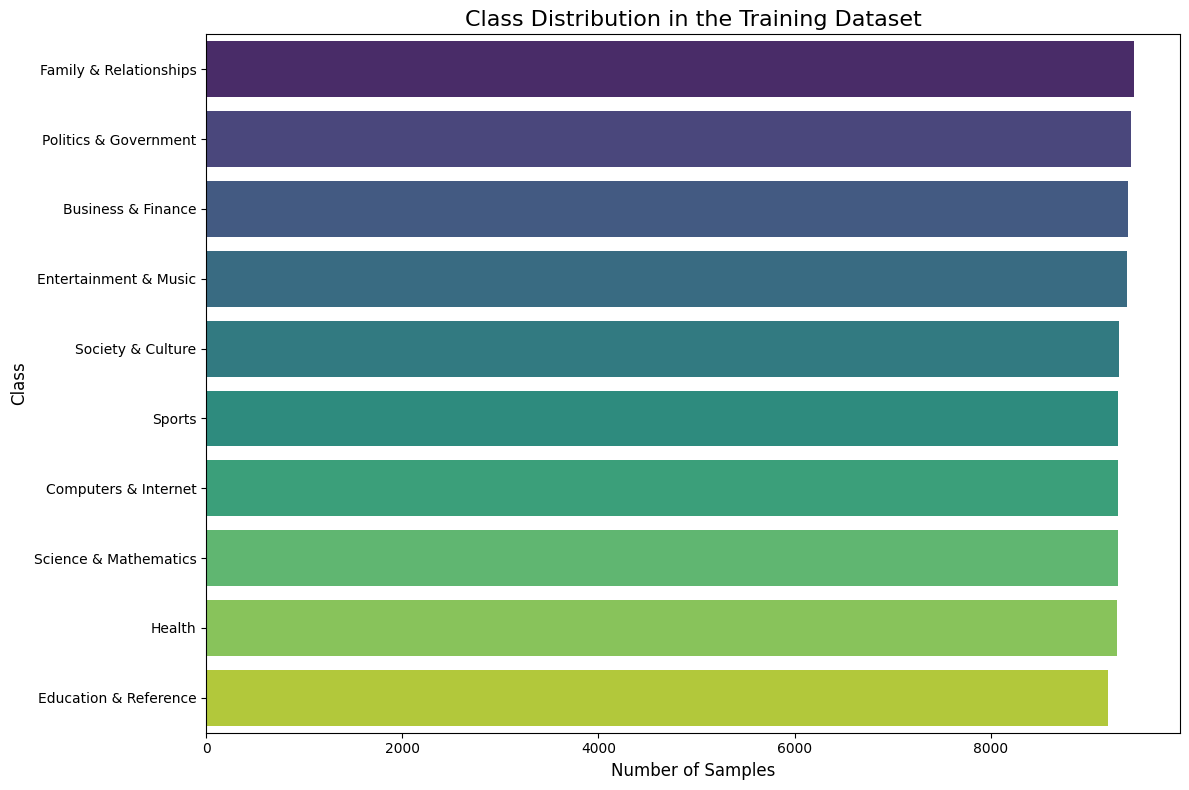

In [ ]:
# Load raw datasets
train_df_raw = pd.read_csv(train_filename)
test_df_raw  = pd.read_csv(test_filename)

print("\n--- EDA on Training Data ---")

# Check dataset shape and info
print(f"Shape of the training dataset: {train_df_raw.shape}")
print(train_df_raw.info())

# Check for missing values
print("\nMissing values in each column:")
print(train_df_raw.isnull().sum())

# Display first few rows
print("\nFirst 3 rows of the training dataset:")
print(train_df_raw.head(3))

# Check class distribution
print("\nClass distribution in training data:")
class_counts = train_df_raw['Class'].value_counts()
print(class_counts)

# Calculate class proportions
print("\nClass proportions:")
class_proportions = train_df_raw['Class'].value_counts(normalize=True) * 100
print(class_proportions.round(2))

# ----------------------------------------------------------------------------
# HTML Content Analysis
# ----------------------------------------------------------------------------
def analyze_html_content(text):
    try:
        text_str = str(text)
        return {
            'total_length': len(text_str),
            'num_html_tags': len(re.findall(r'<[^>]+>', text_str)),
            'num_br_tags': text_str.lower().count('<br'),
            'has_question_title': 'Question Title' in text_str,
            'has_best_answer': 'Best Answer' in text_str,
        }
    except:
        return {
            'total_length': 0,
            'num_html_tags': 0,
            'num_br_tags': 0,
            'has_question_title': False,
            'has_best_answer': False,
        }

sample_size = min(1000, len(train_df_raw))
html_stats = train_df_raw['QA Text'].head(sample_size).apply(analyze_html_content)
html_stats_df = pd.DataFrame(html_stats.tolist())

print("\n📊 HTML Statistics Summary:")
print(f"   Average text length: {html_stats_df['total_length'].mean():.0f} characters")
print(f"   Average HTML tags per text: {html_stats_df['num_html_tags'].mean():.2f}")
print(f"   Texts with <br> tags: {html_stats_df['num_br_tags'].gt(0).sum()}")
print(f"   Texts with 'Question Title': {html_stats_df['has_question_title'].sum()}")
print(f"   Texts with 'Best Answer': {html_stats_df['has_best_answer'].sum()}")

# Class distribution visualization
plt.figure(figsize=(12, 8))
sns.countplot(y=train_df_raw['Class'], order=train_df_raw['Class'].value_counts().index, palette='viridis')
plt.title('Class Distribution in the Training Dataset', fontsize=16)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.tight_layout()
plt.show()

### Text Preprocessing

In [ ]:
# Create formatted copies for processing
train_df = train_df_raw.copy()
test_df  = test_df_raw.copy()

# Rename columns for consistency
train_df = train_df.rename(columns={'QA Text': 'text', 'Class': 'class'})
test_df  = test_df.rename(columns={'QA Text': 'text', 'Class': 'class'})

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit on training data and transform both sets
y_train_encoded = label_encoder.fit_transform(train_df['class'])
y_test_encoded  = label_encoder.transform(test_df['class'])

# Store number of classes
num_classes = len(label_encoder.classes_)

print("✅ DATA PREPROCESSING & LABEL ENCODING COMPLETED SUCCESSFULLY!")

✅ DATA PREPROCESSING & LABEL ENCODING COMPLETED SUCCESSFULLY!


In [ ]:
"""
We will create a function to clean the HTML/code text data and apply it to both
the training and test sets. This involves:
- Converting text to lowercase
- Removing HTML tags
- Removing URLs, punctuation, and numbers
- Tokenizing the text (splitting it into individual words)
- Removing common English stopwords
- Lemmatizing words to their base form
"""

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess HTML/code text for classification
    """
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove structural markers (ADDED THIS)
    text = re.sub(r'question title:?', '', text)
    text = re.sub(r'question content:?', '', text)
    text = re.sub(r'best answer:?', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user @ references and '#'
    text = re.sub(r'\@\w+|\#','', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize words
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return " ".join(cleaned_tokens)

In [ ]:
# ============================================================================
# Apply Preprocessing to Training and Test Data
# ============================================================================

# Apply the preprocessing function to both dataframes
print("Preprocessing training data...")
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

print("Preprocessing test data...")
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

# SANITY CHECKS
print("\n--- Preprocessing Results ---")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("\nSample original vs cleaned text (Training):")
for i in range(2):
    print(f"\nOriginal: {train_df['text'].iloc[i][:200]}...")
    print(f"Cleaned: {train_df['cleaned_text'].iloc[i][:200]}...")

print("\nSample original vs cleaned text (Test):")
for i in range(2):
    print(f"\nOriginal: {test_df['text'].iloc[i][:200]}...")
    print(f"Cleaned: {test_df['cleaned_text'].iloc[i][:200]}...")

Preprocessing training data...
Preprocessing test data...

--- Preprocessing Results ---
Training data shape: (93333, 3)
Test data shape: (59999, 3)

Sample original vs cleaned text (Training):

Original: <html> Question Title:
 <br> what does it mean when you dream of someone you are inlove with?
 <br> <br> <br><br><br> Question Content:
 <br> i havnt seen a guy im inlove with i miss him so much i thi...
Cleaned: mean dream someone inlove havnt seen guy inlove miss much think time want thing happend cant dream time back home family want back thinking obsessed maybe stalker dump havent gotten...

Original: <html> Question Title:
 <br> A huge dam wall at a reservoir . Why are dam walls much wider at the base than they are at the surface?
 <br> <br> <br><br><br> Question Content:
 <br> hihi! this is impor...
Cleaned: huge dam wall reservoir dam wall much wider base surface hihi important please dont crap thx pressure water bottom dam think tonne water dam holding base nnhope help...

Sam

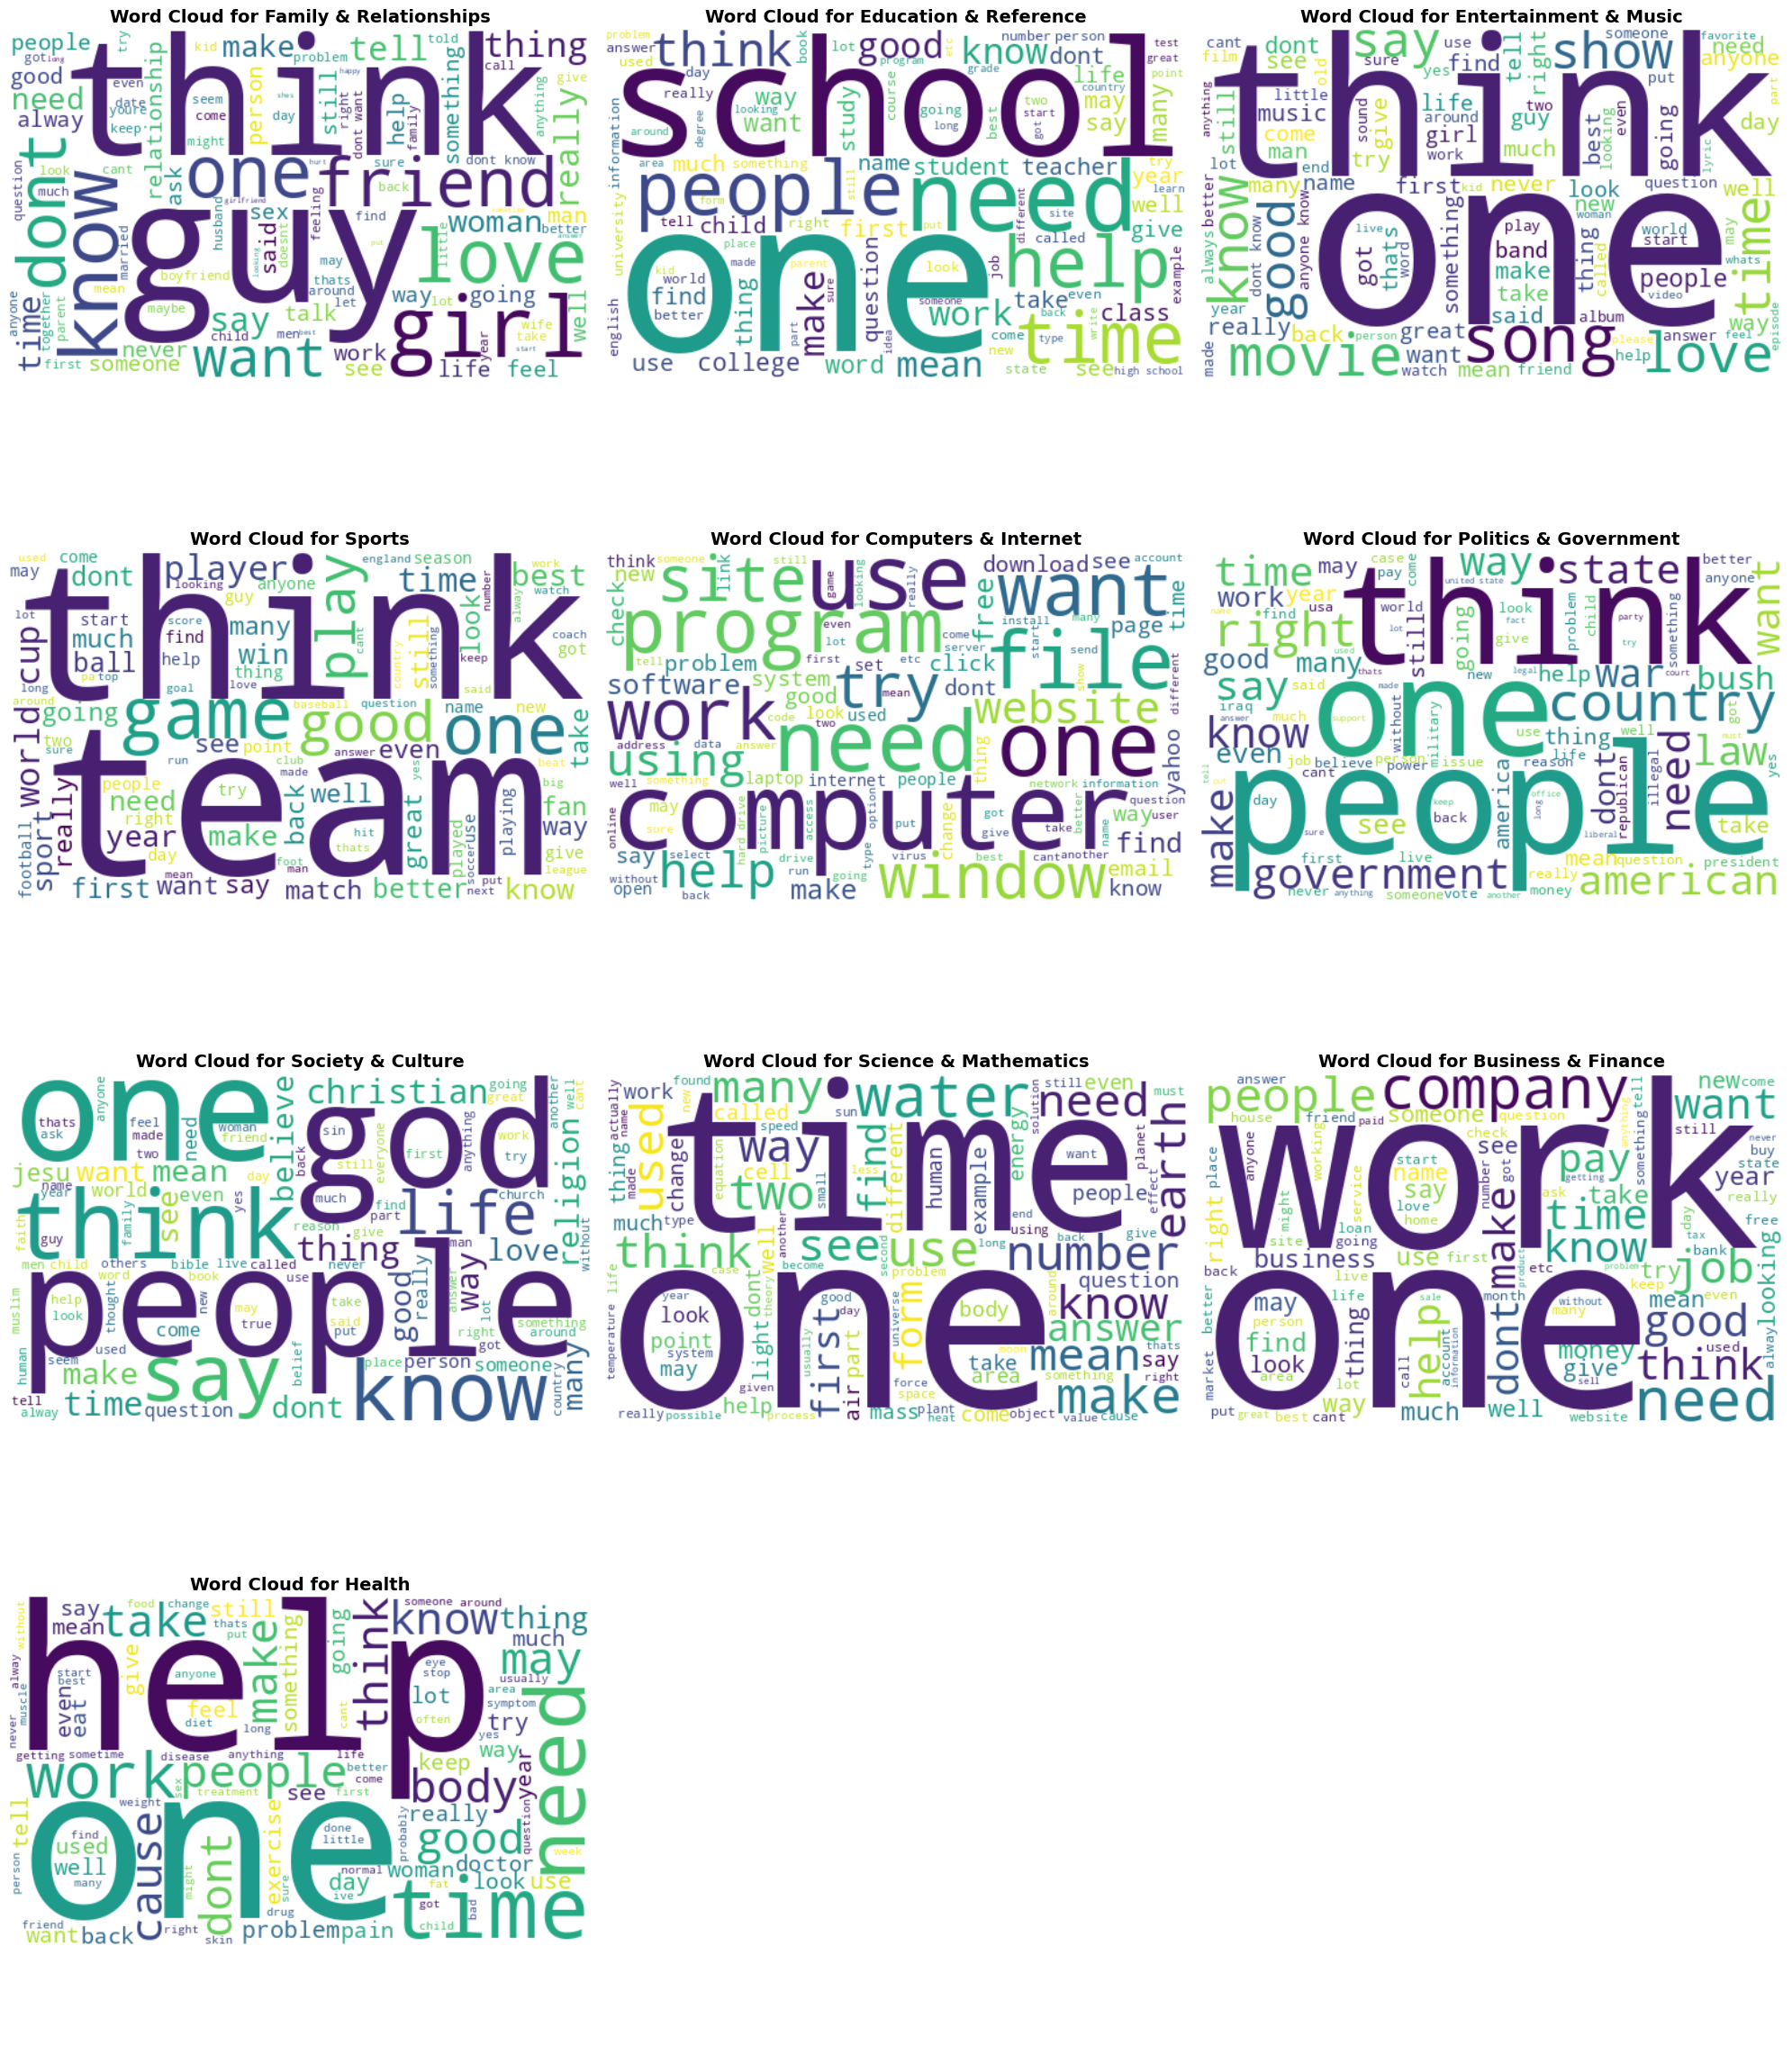

In [ ]:
# ============================================================================
# WORD CLOUD VISUALIZATION (FROM TRAINING DATA)
# ============================================================================

# Let's generate word clouds for each class using the training data to get a
# visual sense of the topics and keywords associated with them.
unique_classes = train_df['class'].unique()
num_classes = len(unique_classes)

# Determine grid size for subplots
cols = 3
rows = (num_classes + cols - 1) // cols  # Calculate rows needed

# Set up the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 6))
axes = axes.flatten()  # Flatten axes for easy indexing

# Generate word clouds
for i, cls in enumerate(unique_classes):
    # Filter data for the current class
    class_texts = train_df[train_df['class'] == cls]['cleaned_text']

    # Combine all texts for the class
    combined_text = ' '.join(class_texts.astype(str))

    # Generate word cloud
    wordcloud = WordCloud(width=500, height=300,
                          background_color='white',
                          colormap='viridis',
                          max_words=100,
                          relative_scaling=0.5,
                          random_state=42).generate(combined_text)

    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for {cls}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

# Hide any extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Prepare features and labels

In [ ]:
# Prepare features and labels
X_train = train_df['cleaned_text']
X_test  = test_df['cleaned_text']

# Use ENCODED labels for ML models
y_train = y_train_encoded
y_test  = y_test_encoded

print(f"\n📊 Dataset Statistics:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Number of classes: {num_classes}")

print(f"\n✅ Labels encoded successfully")
print(f"   Classes: {', '.join(label_encoder.classes_)}")

# Store results
results = {}

print("\n🔧 FEATURE EXTRACTION METHOD:")
print("   TF-IDF - Term frequency with inverse document frequency weighting")
print("\n💡 ADJUSTABLE PARAMETERS:")
print("   • max_features: Vocabulary size (↑ = more features, slower training)")
print("   • ngram_range: N-gram combinations (↑ = richer features, more memory)")
print("   • min_df: Minimum document frequency (↑ = fewer rare words)")


📊 Dataset Statistics:
   Training samples: 93,333
   Test samples: 59,999
   Number of classes: 10

✅ Labels encoded successfully
   Classes: Business & Finance, Computers & Internet, Education & Reference, Entertainment & Music, Family & Relationships, Health, Politics & Government, Science & Mathematics, Society & Culture, Sports

🔧 FEATURE EXTRACTION METHOD:
   TF-IDF - Term frequency with inverse document frequency weighting

💡 ADJUSTABLE PARAMETERS:
   • max_features: Vocabulary size (↑ = more features, slower training)
   • ngram_range: N-gram combinations (↑ = richer features, more memory)
   • min_df: Minimum document frequency (↑ = fewer rare words)


### VALIDATION SPLIT (80% TRAIN, 20% VALIDATION)

In [ ]:
# Split training data: 80% for training, 20% for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded,
    test_size=0.2,        # 20% for validation
    random_state=42,      # For reproducibility
    stratify=y_train_encoded  # Maintain class distribution
)

print(f"\n✅ Training data split completed:")
print(f"   Original training samples: {len(X_train):,}")
print(f"   Training split (80%): {len(X_train_split):,}")
print(f"   Validation split (20%): {len(X_val_split):,}")
print(f"   Test samples (separate): {len(X_test):,}")

# Verify class distribution is maintained
print(f"\n📈 Class distribution verification:")
print(f"   Original: {len(np.unique(y_train_encoded))} classes")
print(f"   Training split: {len(np.unique(y_train_split))} classes")
print(f"   Validation split: {len(np.unique(y_val_split))} classes")

# Store the splits for later use
print(f"\n🎯 Ready for model training with validation!")


✅ Training data split completed:
   Original training samples: 93,333
   Training split (80%): 74,666
   Validation split (20%): 18,667
   Test samples (separate): 59,999

📈 Class distribution verification:
   Original: 10 classes
   Training split: 10 classes
   Validation split: 10 classes

🎯 Ready for model training with validation!


### TF-IDF FEATURES (ONLY METHOD FOR ML MODEL)

In [ ]:
print("\n📈 Creating TF-IDF features...")

# Create TF-IDF vectorizer with tunable parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,    # Limit vocabulary size for speed
    ngram_range=(1, 2),    # Unigrams and bigrams
    min_df=2,              # Ignore terms appearing in less than 2 documents
    max_df=0.95,           # Ignore terms appearing in more than 95% of documents
    stop_words='english'   # Remove English stop words
)

# Fit on training split and transform all datasets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_split)
X_val_tfidf = tfidf_vectorizer.transform(X_val_split)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\n✅ TF-IDF features created:")
print(f"   Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"   Training matrix: {X_train_tfidf.shape}")
print(f"   Validation matrix: {X_val_tfidf.shape}")
print(f"   Test matrix: {X_test_tfidf.shape}")

print(f"\n🎯 READY FOR MACHINE LEARNING EXPERIMENTS!")
print(f"   📊 Training: {X_train_tfidf.shape[0]:,} samples")
print(f"   📊 Validation: {X_val_tfidf.shape[0]:,} samples")
print(f"   🔬 Test: {X_test_tfidf.shape[0]:,} samples")
print(f"   🔤 Features: {X_train_tfidf.shape[1]:,}")
print(f"   🏷️  Classes: {len(label_encoder.classes_)}")


📈 Creating TF-IDF features...

✅ TF-IDF features created:
   Vocabulary size: 10,000
   Training matrix: (74666, 10000)
   Validation matrix: (18667, 10000)
   Test matrix: (59999, 10000)

🎯 READY FOR MACHINE LEARNING EXPERIMENTS!
   📊 Training: 74,666 samples
   📊 Validation: 18,667 samples
   🔬 Test: 59,999 samples
   🔤 Features: 10,000
   🏷️  Classes: 10


### Plotting Function

In [ ]:
# ------------------------------
# Plot training & validation accuracy and loss over epochs
# ------------------------------
def plot_training_history(history, model_name="Model"):
    # Accuracy plot
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'{model_name} Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'{model_name} Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Machine Learning Model Training Function

In [ ]:
def train_and_evaluate_ml_model(model, model_name, X_train_features, X_val_features, X_test_features,
                               y_train, y_val, y_test, feature_type):
    """
    Train and evaluate a machine learning model with the correct data usage strategy:
    1. Train on 80% split, validate on 20% split (for development)
    2. Finally evaluate on separate test dataset (for final assessment)

    Parameters:
    - model: ML model instance
    - model_name: Name of the model
    - X_train_features: Training features (80% split)
    - X_val_features: Validation features (20% split)
    - X_test_features: Test features (separate dataset)
    - y_train: Training labels (80% split)
    - y_val: Validation labels (20% split)
    - y_test: Test labels (separate dataset)
    - feature_type: Type of features used (TF-IDF, Word2Vec, etc.)

    Returns:
    - Dictionary with evaluation results
    """

    print(f"\n{'='*60}")
    print(f"🔍 TRAINING: {model_name} with {feature_type}")
    print(f"{'='*60}")

    # Train the model on 80% split
    start_time = time.time()
    model.fit(X_train_features, y_train)
    training_time = time.time() - start_time

    # Validate on 20% split (for development)
    y_val_pred = model.predict(X_val_features)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1_macro = f1_score(y_val, y_val_pred, average='macro')

    # Final evaluation on test dataset
    y_test_pred = model.predict(X_test_features)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} ({feature_type})')
    plt.show()

    # Classification report
    print(f"\nClassification Report - {model_name} ({feature_type}):\n")
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

    print(f"\n⏱️  Training time: {training_time:.2f} seconds")
    print(f"📊 Validation accuracy: {val_accuracy:.4f}")
    print(f"📊 Test accuracy: {test_accuracy:.4f}")
    print(f"📊 Validation F1-macro: {val_f1_macro:.4f}")
    print(f"📊 Test F1-macro: {test_f1_macro:.4f}")

    return {
        'Validation_Accuracy': val_accuracy,
        'Test_Accuracy': test_accuracy,
        'Validation_F1-Macro': val_f1_macro,
        'Test_F1-Macro': test_f1_macro,
        'Training_Time': training_time,
        'Validation_Predictions': y_val_pred,
        'Test_Predictions': y_test_pred,
        'Confusion_Matrix': cm
    }

print("✅ ML training function updated with confusion matrix and classification report")

✅ ML training function updated with confusion matrix and classification report


# Naive Bayes Classifier With TF-IDF


🧪 STARTING EXPERIMENT 1: Naive Bayes Hyperparameter Tuning
Trial    | Alpha      | Validation Accuracy 
---------------------------------------------
1        | 0.01       | 0.6705
2        | 0.1        | 0.6738
3        | 0.5        | 0.6745
4        | 1.0        | 0.6736
5        | 5.0        | 0.6651
6        | 10.0       | 0.6525
---------------------------------------------
🏆 Best Hyperparameter Found: Alpha = 0.5
   Best Validation Accuracy:  0.6745
🚀 Retraining Final Naive Bayes Model with alpha=0.5...

🔍 TRAINING: Naive Bayes with TF-IDF


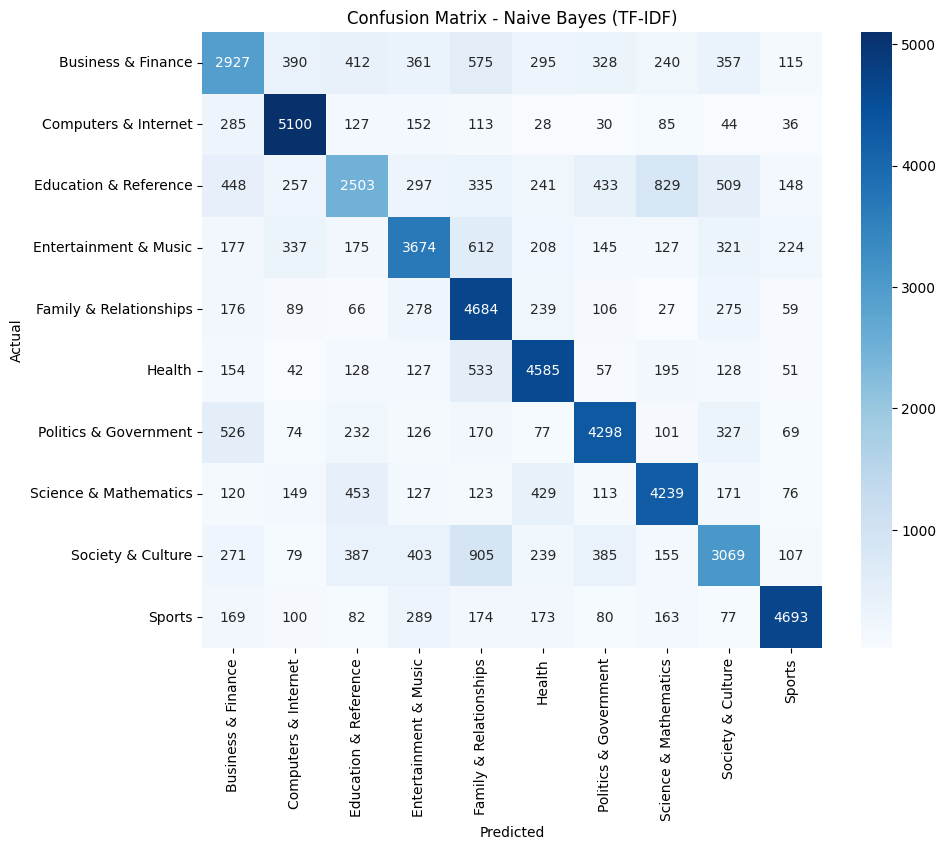


Classification Report - Naive Bayes (TF-IDF):

                        precision    recall  f1-score   support

    Business & Finance       0.56      0.49      0.52      6000
  Computers & Internet       0.77      0.85      0.81      6000
 Education & Reference       0.55      0.42      0.47      6000
 Entertainment & Music       0.63      0.61      0.62      6000
Family & Relationships       0.57      0.78      0.66      5999
                Health       0.70      0.76      0.73      6000
 Politics & Government       0.72      0.72      0.72      6000
 Science & Mathematics       0.69      0.71      0.70      6000
     Society & Culture       0.58      0.51      0.54      6000
                Sports       0.84      0.78      0.81      6000

              accuracy                           0.66     59999
             macro avg       0.66      0.66      0.66     59999
          weighted avg       0.66      0.66      0.66     59999


⏱️  Training time: 0.02 seconds
📊 Validation accurac

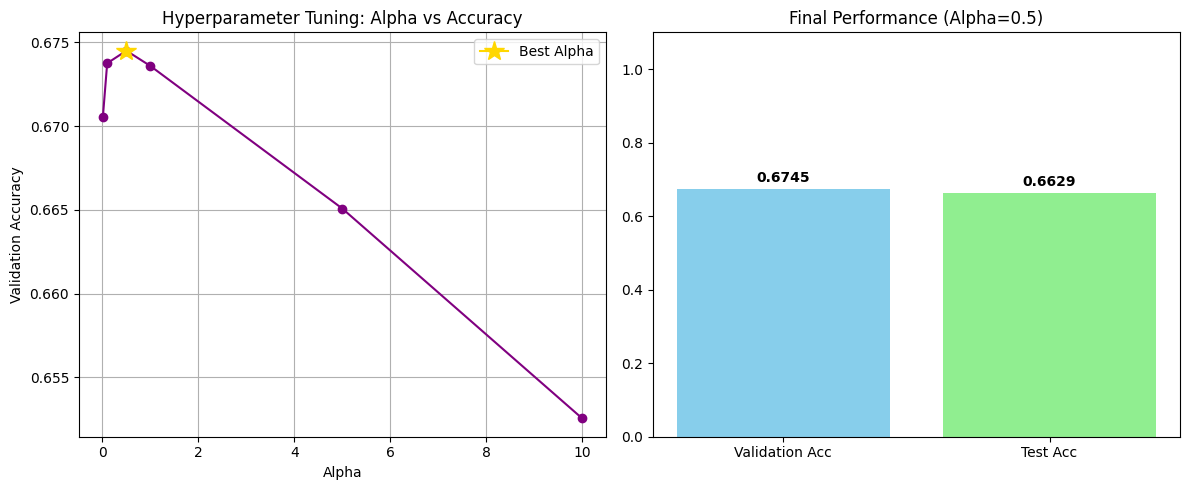

✅ Naive Bayes experiment completed!


In [ ]:
# ============================================================================
# EXPERIMENT 1: NAIVE BAYES + TF-IDF (WITH VISIBLE TUNING TRIALS)
# ============================================================================
print("\n🧪 STARTING EXPERIMENT 1: Naive Bayes Hyperparameter Tuning")
print("="*60)

# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (The "Trials")
# ------------------------------------------------------------------
# We test different 'alpha' values (smoothing parameter)
alphas_to_test = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]

print(f"{'Trial':<8} | {'Alpha':<10} | {'Validation Accuracy':<20}")
print("-" * 45)

best_alpha = 1.0
best_val_score = 0.0
tuning_history = []

for i, alpha in enumerate(alphas_to_test):
    # Train a temporary model on the Training Split
    temp_model = MultinomialNB(alpha=alpha)
    temp_model.fit(X_train_tfidf, y_train_split)

    # Evaluate on the Validation Split
    val_score = temp_model.score(X_val_tfidf, y_val_split)

    # Print the result for this trial
    print(f"{i+1:<8} | {alpha:<10} | {val_score:.4f}")

    # Record history
    tuning_history.append((alpha, val_score))

    # Track the winner
    if val_score > best_val_score:
        best_val_score = val_score
        best_alpha = alpha

print("-" * 45)
print(f"🏆 Best Hyperparameter Found: Alpha = {best_alpha}")
print(f"   Best Validation Accuracy:  {best_val_score:.4f}")
print("="*60)

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING (Using Best Alpha)
# ------------------------------------------------------------------
print(f"🚀 Retraining Final Naive Bayes Model with alpha={best_alpha}...")

# Initialize model with the WINNING parameter
nb_tfidf_model = MultinomialNB(alpha=best_alpha)

# Call your helper function to train and evaluate
# Note: We use the splits here as standard practice, but the parameter
# was selected based on the tuning above.
nb_tfidf_results = train_and_evaluate_ml_model(
    nb_tfidf_model, "Naive Bayes", X_train_tfidf, X_val_tfidf, X_test_tfidf,
    y_train_split, y_val_split, y_test_encoded, "TF-IDF"
)

# ------------------------------------------------------------------
# STEP 3: STORE RESULTS & VISUALIZE
# ------------------------------------------------------------------
print(f"\n📊 NAIVE BAYES FINAL SUMMARY:")
print(f"   Test Accuracy: {nb_tfidf_results['Test_Accuracy']:.4f}")
print(f"   F1-Macro:      {nb_tfidf_results['Test_F1-Macro']:.4f}")

# Store results in the main dictionary
results['Naive Bayes + TF-IDF'] = {
    'Accuracy': nb_tfidf_results['Test_Accuracy'],
    'F1-Macro': nb_tfidf_results['Test_F1-Macro'],
    'Training Time': nb_tfidf_results['Training_Time']
}

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Hyperparameter Tuning Results
alphas_plot, scores_plot = zip(*tuning_history)
ax1.plot(alphas_plot, scores_plot, marker='o', linestyle='-', color='purple')
ax1.set_title('Hyperparameter Tuning: Alpha vs Accuracy')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
# Highlight the best point
ax1.plot(best_alpha, best_val_score, marker='*', color='gold', markersize=15, label='Best Alpha')
ax1.legend()

# Plot 2: Final Test Metrics
metrics = ['Validation Acc', 'Test Acc']
values = [nb_tfidf_results['Validation_Accuracy'], nb_tfidf_results['Test_Accuracy']]
bars = ax2.bar(metrics, values, color=['skyblue', 'lightgreen'])
ax2.set_title(f'Final Performance (Alpha={best_alpha})')
ax2.set_ylim(0, 1.1)
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Naive Bayes experiment completed!")


🧠 EXPERIMENT 2/9: DEEP NEURAL NETWORK (DNN) + TF-IDF (DUAL GPU)
⚙️ Converting TF-IDF matrices to dense arrays (this uses RAM)...

🧪 STARTING TUNING TRIALS...
Trial    | Config                              | Val Accuracy   
-----------------------------------------------------------------
1        | Light (512 units, 0.5 drop)         | 0.6830
2        | Heavy (1024 units, 0.3 drop)        | 0.6777
-----------------------------------------------------------------
🏆 Best Architecture: Light (512 units, 0.5 drop)
🚀 Training Final DNN Model (Light (512 units, 0.5 drop))...
Epoch 1/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5494 - loss: 1.4141 - val_accuracy: 0.6820 - val_loss: 0.9990
Epoch 2/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7221 - loss: 0.8719 - val_accuracy: 0.6708 - val_loss: 1.0602
Epoch 3/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7770 - loss: 0.6924 - val_accuracy: 0.6595 - val_loss: 1.1854
Epoch 4/20
1167/1167 ━━━━━━

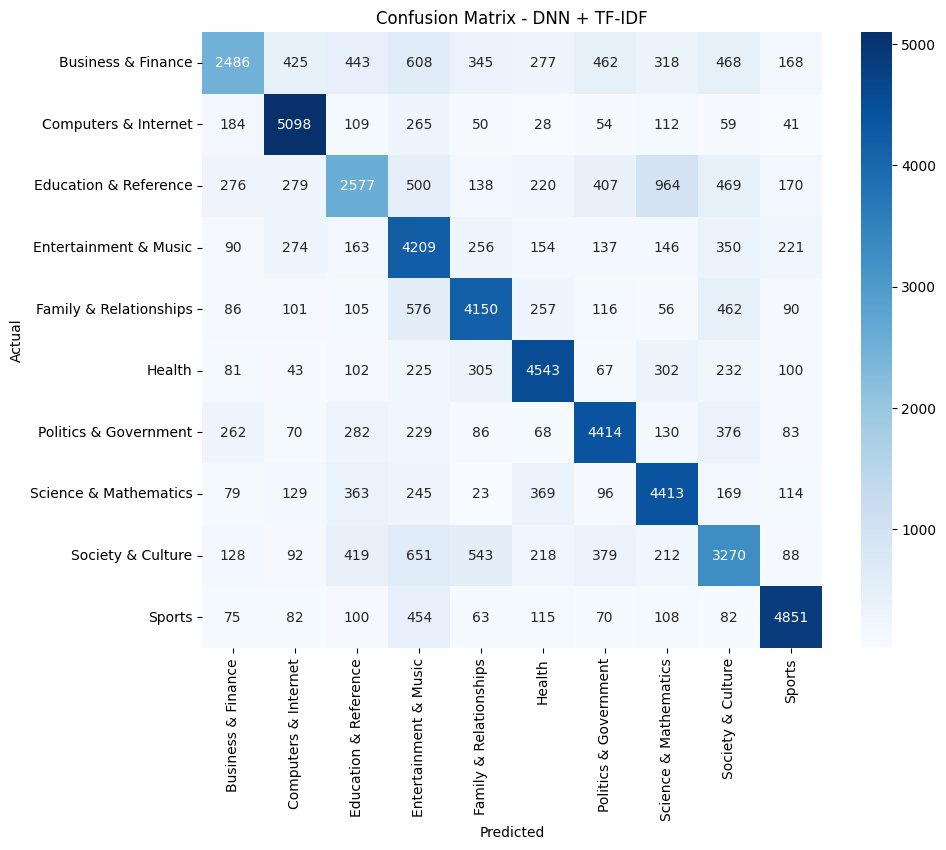

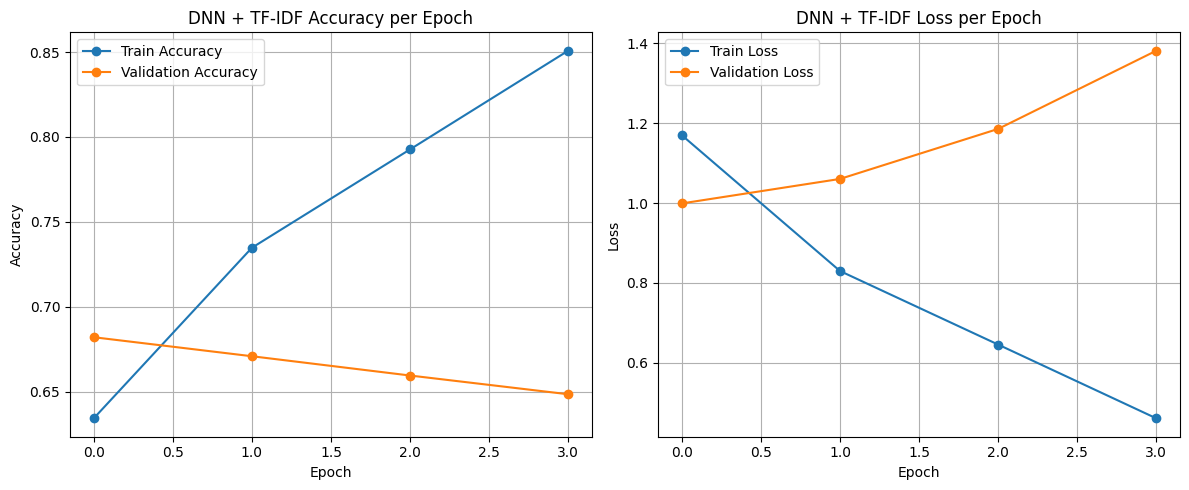

🧹 Dense arrays deleted from RAM to prepare for Word2Vec.


In [ ]:
# ============================================================================
# EXPERIMENT 2: DEEP NEURAL NETWORK (DNN) + TF-IDF (DUAL GPU ENABLED)
# ============================================================================
print("\n" + "="*60)
print("🧠 EXPERIMENT 2/9: DEEP NEURAL NETWORK (DNN) + TF-IDF (DUAL GPU)")
print("="*60)

# 2. Convert Sparse Matrices to Dense (Required for Dense Layers)
print("⚙️ Converting TF-IDF matrices to dense arrays (this uses RAM)...")
X_train_dense = X_train_tfidf.toarray()
X_val_dense   = X_val_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (The Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<35} | {'Val Accuracy':<15}")
print("-" * 65)

configs = [
    {'id': 1, 'units': 512,  'dropout': 0.5, 'desc': 'Light (512 units, 0.5 drop)'},
    {'id': 2, 'units': 1024, 'dropout': 0.3, 'desc': 'Heavy (1024 units, 0.3 drop)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    with strategy.scope():
        model = Sequential([
            Dense(conf['units'], activation='relu', input_shape=(X_train_dense.shape[1],)),
            Dropout(conf['dropout']),
            Dense(conf['units'] // 2, activation='relu'),
            Dropout(conf['dropout'] / 1.5),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train briefly
    h = model.fit(X_train_dense, y_train_split,
                  validation_data=(X_val_dense, y_val_split),
                  epochs=5, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<35} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 65)
print(f"🏆 Best Architecture: {best_config['desc']}")
print("="*60)

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING (With Best Architecture)
# ------------------------------------------------------------------
print(f"🚀 Training Final DNN Model ({best_config['desc']})...")

with strategy.scope():
    dnn_model = Sequential([
        Dense(best_config['units'], activation='relu', input_shape=(X_train_dense.shape[1],)),
        Dropout(best_config['dropout']),
        Dense(best_config['units'] // 2, activation='relu'),
        Dropout(best_config['dropout'] / 1.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history_dnn = dnn_model.fit(
    X_train_dense, y_train_split,
    validation_data=(X_val_dense, y_val_split),
    epochs=20,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
train_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION & STORAGE
# ------------------------------------------------------------------
print("\n🔍 Evaluating on Test Set...")
y_pred_probs = dnn_model.predict(X_test_dense, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_encoded, y_pred)
test_f1 = f1_score(y_test_encoded, y_pred, average='macro')

# Store results
results['DNN + TF-IDF'] = {
    'Accuracy': test_acc,
    'F1-Macro': test_f1,
    'Training Time': train_time
}

print(f"\n✅ DNN + TF-IDF Final Results:")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test F1-Macro: {test_f1:.4f}")

# --- ADDED: Classification Report & Confusion Matrix ---
print("\nClassification Report:\n")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Visuals
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - DNN + TF-IDF')
plt.show()

plot_training_history(history_dnn, "DNN + TF-IDF")

# ------------------------------------------------------------------
# STEP 4: MEMORY CLEANUP
# ------------------------------------------------------------------
del X_train_dense, X_val_dense, X_test_dense, dnn_model
tf.keras.backend.clear_session()
gc.collect()
print("🧹 Dense arrays deleted from RAM to prepare for Word2Vec.")

### Skipgram Representation

In [ ]:
# ============================================================================
# PREPARE DATA FOR DEEP LEARNING (WORD2VEC + TOKENIZATION)
# ============================================================================

print("\n⚙️ PREPARING WORD EMBEDDINGS AND SEQUENCES...")

# 1. Tokenize for Word2Vec Training
print("   Tokenizing text for Word2Vec...")
train_tokens = [text.split() for text in train_df['cleaned_text']]
test_tokens  = [text.split() for text in test_df['cleaned_text']]

# 2. Train Word2Vec (Skip-gram)
print("   Training Word2Vec model (this may take a moment)...")
embedding_size = 100
window_size = 5
min_word_count = 2
workers = 4

w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=embedding_size,
    window=window_size,
    min_count=min_word_count,
    sg=1,  # Skip-gram
    workers=workers,
    seed=42
)

print(f"   ✅ Word2Vec Trained. Vocab size: {len(w2v_model.wv.index_to_key)}")

# 3. Keras Tokenization (Words -> Integers)
print("   Converting text to integer sequences...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['cleaned_text'])
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding index 0

X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_seq  = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# 4. Padding Sequences
max_seq_len = 100
print(f"   Padding sequences to length {max_seq_len}...")
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post')

# 5. Create Embedding Matrix
print("   Creating Embedding Matrix...")
embedding_matrix = np.zeros((vocab_size, embedding_size))
hits = 0
misses = 0

for word, idx in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
        hits += 1
    else:
        misses += 1

print(f"   ✅ Embedding Matrix shape: {embedding_matrix.shape}")
print(f"      Hits: {hits}, Misses: {misses}")

# 6. CRITICAL STEP: Validation Split
# We split the PADDED training data into Train (80%) and Validation (20%)
print("   Splitting padded data into Train/Validation sets...")

X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_pad, y_train_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_train_encoded
)

print(f"\n✅ Deep Learning Data Ready:")
print(f"   Training Input:   {X_train_dl.shape}")
print(f"   Validation Input: {X_val_dl.shape}")
print(f"   Test Input:       {X_test_pad.shape}")


⚙️ PREPARING WORD EMBEDDINGS AND SEQUENCES...
   Tokenizing text for Word2Vec...
   Training Word2Vec model (this may take a moment)...
   ✅ Word2Vec Trained. Vocab size: 75328
   Converting text to integer sequences...
   Padding sequences to length 100...
   Creating Embedding Matrix...
   ✅ Embedding Matrix shape: (274489, 100)
      Hits: 75328, Misses: 199160
   Splitting padded data into Train/Validation sets...

✅ Deep Learning Data Ready:
   Training Input:   (74666, 100)
   Validation Input: (18667, 100)
   Test Input:       (59999, 100)


### Deep Neural Network (DNN)

Prepare validation split

In [ ]:
# Labels for neural network
y_train_nn = y_train_encoded
y_test_nn  = y_test_encoded

# Validation split (80% train, 20% validation)
X_train_nn, X_val_nn, y_train_nn_split, y_val_nn_split = train_test_split(
    X_train_pad, y_train_nn,
    test_size=0.2,
    stratify=y_train_nn,
    random_state=42
)

print(f"Training shape: {X_train_nn.shape}, Validation shape: {X_val_nn.shape}")

Training shape: (74666, 100), Validation shape: (18667, 100)


Build the DNN directly and Train it


🧠 EXPERIMENT 3/9: DNN + WORD2VEC (DUAL GPU)

🧪 STARTING TUNING TRIALS...
Trial    | Config                         | Val Accuracy   
------------------------------------------------------------
1        | Standard (128 -> 64)           | 0.6000
2        | Complex (256 -> 128)           | 0.6002
------------------------------------------------------------
🏆 Best Architecture: Complex (256 -> 128)
🚀 Training Final DNN + Word2Vec Model (Complex (256 -> 128))...
Epoch 1/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4185 - loss: 1.7076 - val_accuracy: 0.5843 - val_loss: 1.2689
Epoch 2/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5587 - loss: 1.3587 - val_accuracy: 0.5963 - val_loss: 1.2481
Epoch 3/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5718 - loss: 1.3311 - val_accuracy: 0.5943 - val_loss: 1.2365
Epoch 4/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5755 - loss: 1.3164 - val_accuracy: 0.6000 - val_loss: 1.2243
Epoch 5/20
116

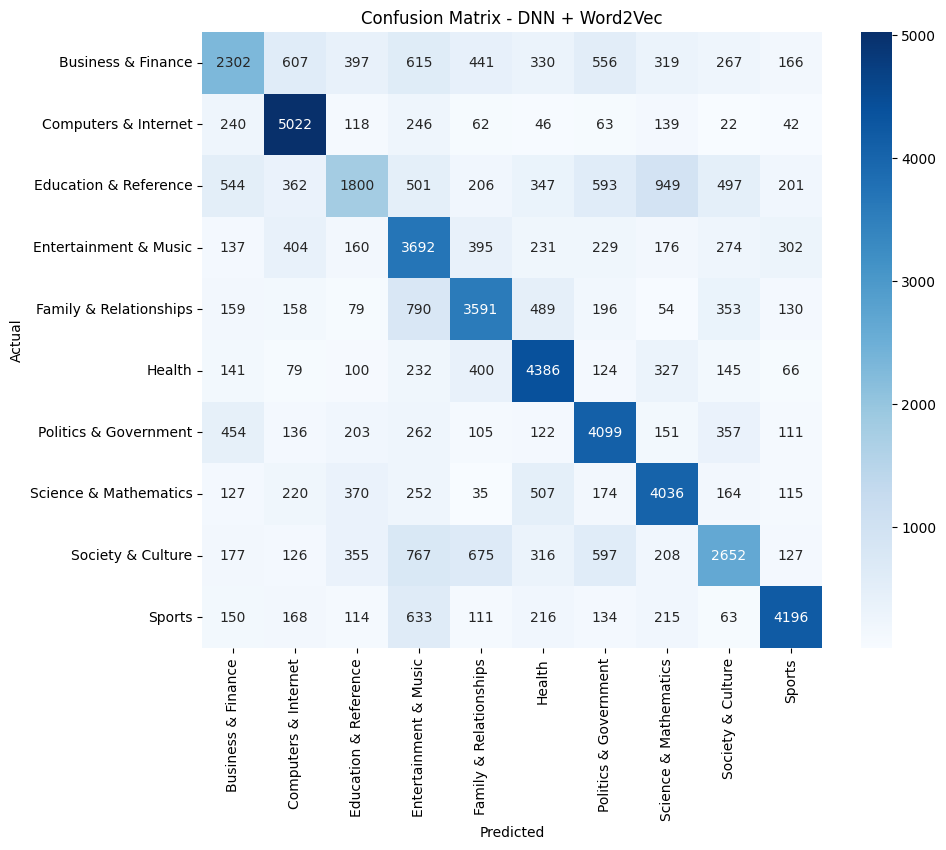

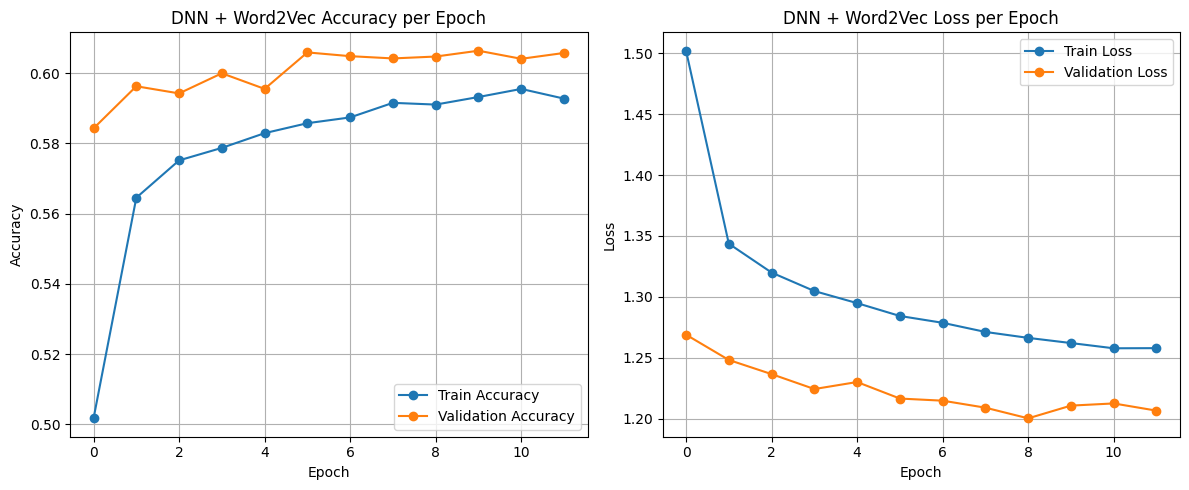

0

In [ ]:
# ============================================================================
# EXPERIMENT 3: DNN + WORD2VEC (DUAL GPU ENABLED)
# ============================================================================

print("\n" + "="*60)
print("🧠 EXPERIMENT 3/9: DNN + WORD2VEC (DUAL GPU)")
print("="*60)

# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (The Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<30} | {'Val Accuracy':<15}")
print("-" * 60)

# We test two architectures
configs = [
    {'id': 1, 'l1': 128, 'l2': 64,  'drop': 0.3, 'desc': 'Standard (128 -> 64)'},
    {'id': 2, 'l1': 256, 'l2': 128, 'drop': 0.4, 'desc': 'Complex (256 -> 128)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    # WRAPPER FOR DUAL GPU
    with strategy.scope():
        model = Sequential([
            Embedding(input_dim=vocab_size,
                      output_dim=embedding_size,
                      weights=[embedding_matrix],
                      input_length=max_seq_len,
                      trainable=False),  # Freeze Skip-gram embeddings
            GlobalMaxPooling1D(),        # Pooling instead of Flatten
            Dense(conf['l1'], activation='relu'),
            Dropout(conf['drop']),
            Dense(conf['l2'], activation='relu'),
            Dropout(conf['drop'] / 1.5),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Batch size scaled for Dual GPU
    h = model.fit(X_train_nn, y_train_nn_split,
                  validation_data=(X_val_nn, y_val_nn_split),
                  epochs=5, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<30} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 60)
print(f"🏆 Best Architecture: {best_config['desc']}")
print("="*60)

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING (With Best Config)
# ------------------------------------------------------------------
print(f"🚀 Training Final DNN + Word2Vec Model ({best_config['desc']})...")

with strategy.scope():
    dnn_skip_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_size,
                  weights=[embedding_matrix], input_length=max_seq_len, trainable=False),
        GlobalMaxPooling1D(),
        Dense(best_config['l1'], activation='relu'),
        Dropout(best_config['drop']),
        Dense(best_config['l2'], activation='relu'),
        Dropout(best_config['drop'] / 1.5),
        Dense(num_classes, activation='softmax')
    ])

    dnn_skip_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with Early Stopping (Using Global Batch Size)
start_time = time.time()
history_skip = dnn_skip_model.fit(
    X_train_nn, y_train_nn_split,
    validation_data=(X_val_nn, y_val_nn_split),
    epochs=20,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
train_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION & STORAGE
# ------------------------------------------------------------------
print("\n🔍 Evaluating DNN + Word2Vec...")
y_pred_probs = dnn_skip_model.predict(X_test_pad, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_nn, y_pred)
test_f1 = f1_score(y_test_nn, y_pred, average='macro')

print(f"\n✅ DNN + Word2Vec Results:")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test F1-Macro: {test_f1:.4f}")

# Store results
results['DNN + Word2Vec'] = {
    'Accuracy': test_acc,
    'F1-Macro': test_f1,
    'Training Time': train_time
}

# --- ADDED: Classification Report & Confusion Matrix ---
print("\nClassification Report:\n")
print(classification_report(y_test_nn, y_pred, target_names=label_encoder.classes_))

# Visuals
cm = confusion_matrix(y_test_nn, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - DNN + Word2Vec')
plt.show()

# Plot History
plot_training_history(history_skip, "DNN + Word2Vec")

# Cleanup
del dnn_skip_model
tf.keras.backend.clear_session()
gc.collect()

### SimpleRNN


🧠 EXPERIMENT 4/9: SIMPLE RNN + WORD2VEC (DUAL GPU)

🧪 STARTING TUNING TRIALS...
Trial    | Config                         | Val Accuracy   
------------------------------------------------------------
1        | Light (64 units, 0.2 drop)     | 0.6852
2        | Heavy (128 units, 0.3 drop)    | 0.6774
------------------------------------------------------------
🏆 Best Architecture: Light (64 units, 0.2 drop)
🚀 Training Final SimpleRNN Model (Light (64 units, 0.2 drop))...
Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 131s 111ms/step - accuracy: 0.4314 - loss: 1.7043 - val_accuracy: 0.6531 - val_loss: 1.0931
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 129s 110ms/step - accuracy: 0.6386 - loss: 1.1450 - val_accuracy: 0.6700 - val_loss: 1.0370
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 128s 110ms/step - accuracy: 0.6538 - loss: 1.0944 - val_accuracy: 0.6762 - val_loss: 1.0192
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 128s 110ms/step - accuracy: 0.6608 - loss: 1.0790 - val_accuracy: 0.6778 - val

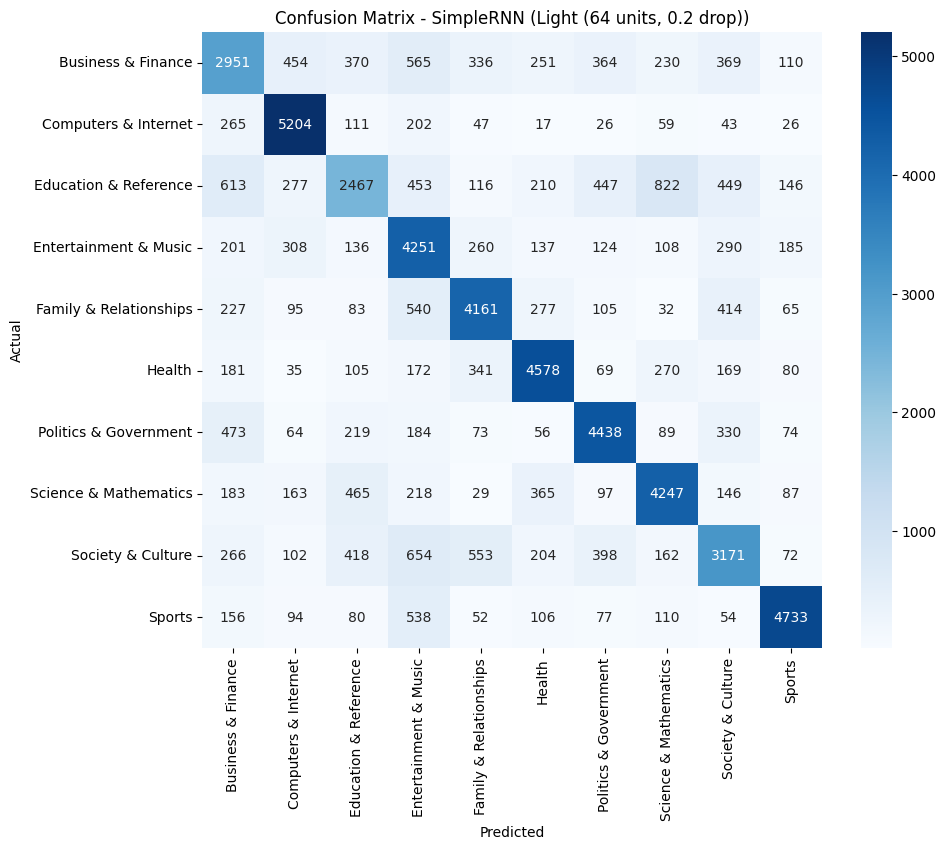


Classification Report:

                        precision    recall  f1-score   support

    Business & Finance       0.53      0.49      0.51      6000
  Computers & Internet       0.77      0.87      0.81      6000
 Education & Reference       0.55      0.41      0.47      6000
 Entertainment & Music       0.55      0.71      0.62      6000
Family & Relationships       0.70      0.69      0.70      5999
                Health       0.74      0.76      0.75      6000
 Politics & Government       0.72      0.74      0.73      6000
 Science & Mathematics       0.69      0.71      0.70      6000
     Society & Culture       0.58      0.53      0.55      6000
                Sports       0.85      0.79      0.82      6000

              accuracy                           0.67     59999
             macro avg       0.67      0.67      0.67     59999
          weighted avg       0.67      0.67      0.67     59999



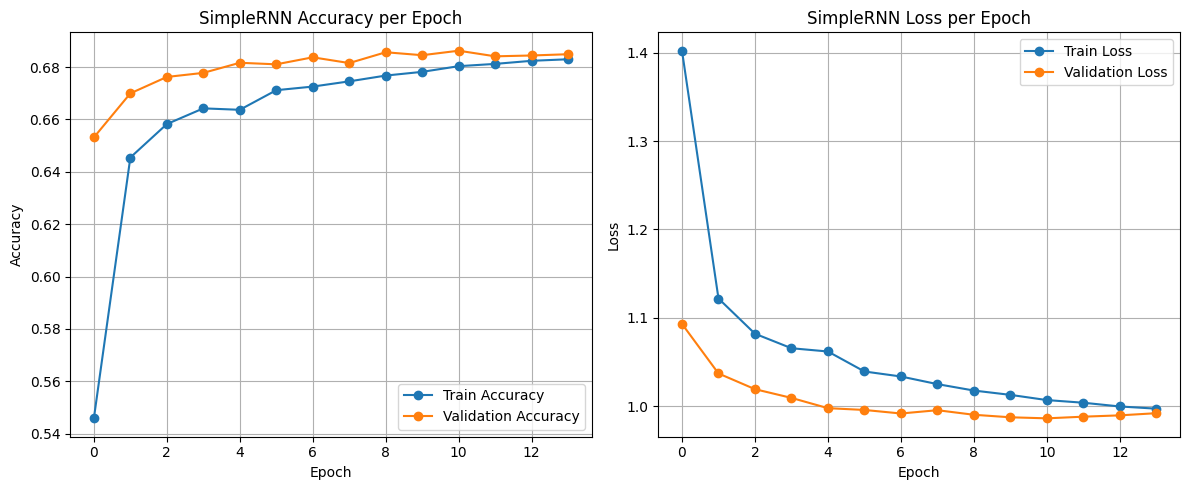

0

In [ ]:
# ============================================================================
# EXPERIMENT 4: SIMPLE RNN + WORD2VEC (DUAL GPU ENABLED)
# ============================================================================
print("\n" + "="*60)
print("🧠 EXPERIMENT 4/9: SIMPLE RNN + WORD2VEC (DUAL GPU)")
print("="*60)


# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (The Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<30} | {'Val Accuracy':<15}")
print("-" * 60)

# We test two distinct configurations
configs = [
    {'id': 1, 'units': 64,  'drop': 0.2, 'desc': 'Light (64 units, 0.2 drop)'},
    {'id': 2, 'units': 128, 'drop': 0.3, 'desc': 'Heavy (128 units, 0.3 drop)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    # WRAPPER FOR DUAL GPU
    with strategy.scope():
        # Build Model (Architecture remains EXACTLY as requested)
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_size,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_seq_len, trainable=False),

            SimpleRNN(conf['units'], return_sequences=True, recurrent_dropout=0),
            GlobalMaxPooling1D(),

            # External Dropout
            Dropout(0.3),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Short training for tuning (Batch size scaled)
    h = model.fit(X_train_nn, y_train_nn_split,
                  validation_data=(X_val_nn, y_val_nn_split),
                  epochs=5, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<30} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 60)
print(f"🏆 Best Architecture: {best_config['desc']}")
print("="*60)

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING (With Best Config)
# ------------------------------------------------------------------
print(f"🚀 Training Final SimpleRNN Model ({best_config['desc']})...")

with strategy.scope():
    simple_rnn_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_size,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=max_seq_len, trainable=False),

        SimpleRNN(best_config['units'], return_sequences=True, recurrent_dropout=0),
            GlobalMaxPooling1D(),

            # External Dropout
            Dropout(0.3),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    simple_rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with Early Stopping (Batch size scaled)
start_time = time.time()
history_rnn = simple_rnn_model.fit(
    X_train_nn, y_train_nn_split,
    validation_data=(X_val_nn, y_val_nn_split),
    epochs=15,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
training_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION & STORAGE
# ------------------------------------------------------------------
print("\n🔍 Evaluating SimpleRNN...")
y_pred_probs = simple_rnn_model.predict(X_test_pad, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_nn, y_pred)
test_f1 = f1_score(y_test_nn, y_pred, average='macro')

print(f"\n✅ SimpleRNN + Word2Vec Results:")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test F1-Macro: {test_f1:.4f}")

# Store results
results['SimpleRNN + Word2Vec'] = {
    'Accuracy': test_acc,
    'F1-Macro': test_f1,
    'Training Time': training_time
}

# Confusion Matrix
cm = confusion_matrix(y_test_nn, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - SimpleRNN ({best_config["desc"]})')
plt.show()

# Classification Report & History
print("\nClassification Report:\n")
print(classification_report(y_test_nn, y_pred, target_names=label_encoder.classes_))
plot_training_history(history_rnn, model_name="SimpleRNN")

# Cleanup
del simple_rnn_model
tf.keras.backend.clear_session()
gc.collect()

### GRU


🧠 EXPERIMENT: GRU + WORD2VEC (GPU ACCELERATED)

🧪 STARTING TUNING TRIALS...
Trial    | Config                         | Val Accuracy   
------------------------------------------------------------


I0000 00:00:1767345118.067001     134 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767345118.067019     135 cuda_dnn.cc:529] Loaded cuDNN version 91002


1        | Light (64 units)               | 0.6911
2        | Heavy (128 units)              | 0.6971
------------------------------------------------------------
🏆 Best Architecture: Heavy (128 units)
🚀 Training Final GRU Model...
Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5658 - loss: 1.3408 - val_accuracy: 0.6823 - val_loss: 0.9944
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6748 - loss: 1.0242 - val_accuracy: 0.6945 - val_loss: 0.9563
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6855 - loss: 0.9875 - val_accuracy: 0.6989 - val_loss: 0.9464
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6914 - loss: 0.9642 - val_accuracy: 0.7030 - val_loss: 0.9369
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6966 - loss: 0.9447 - val_accuracy: 0.7021 - val_loss: 0.9333
Epoch 6/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6998 - loss: 0.9341 - val_accuracy: 0.

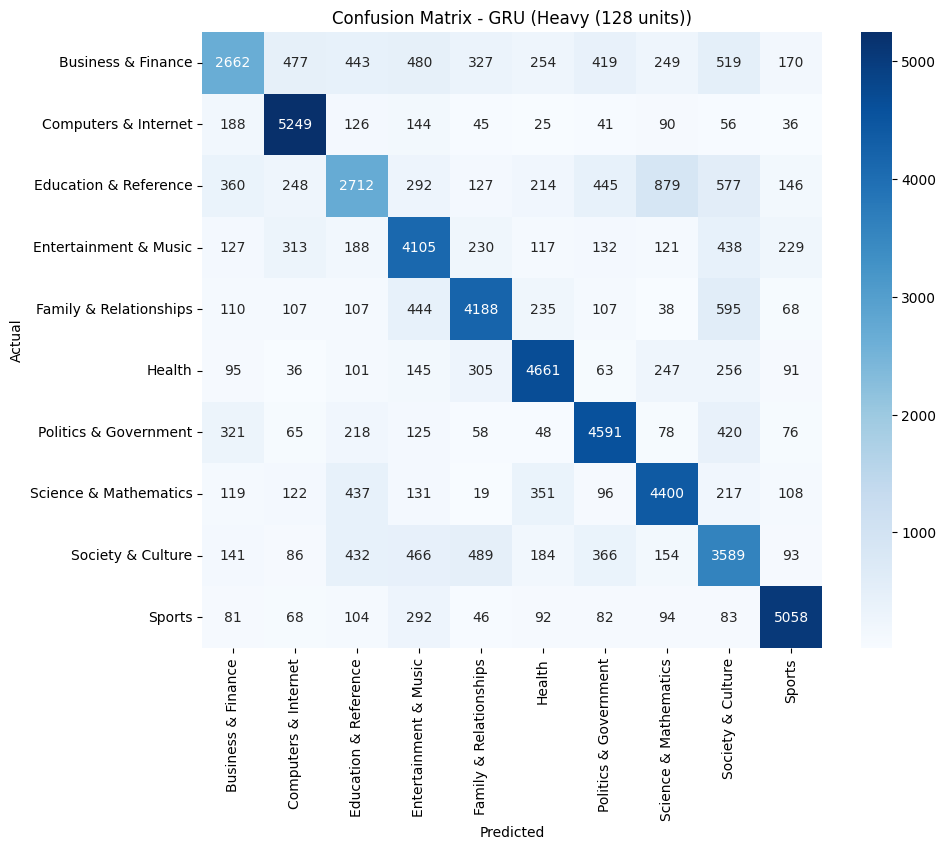

                        precision    recall  f1-score   support

    Business & Finance       0.63      0.44      0.52      6000
  Computers & Internet       0.78      0.87      0.82      6000
 Education & Reference       0.56      0.45      0.50      6000
 Entertainment & Music       0.62      0.68      0.65      6000
Family & Relationships       0.72      0.70      0.71      5999
                Health       0.75      0.78      0.77      6000
 Politics & Government       0.72      0.77      0.74      6000
 Science & Mathematics       0.69      0.73      0.71      6000
     Society & Culture       0.53      0.60      0.56      6000
                Sports       0.83      0.84      0.84      6000

              accuracy                           0.69     59999
             macro avg       0.68      0.69      0.68     59999
          weighted avg       0.68      0.69      0.68     59999



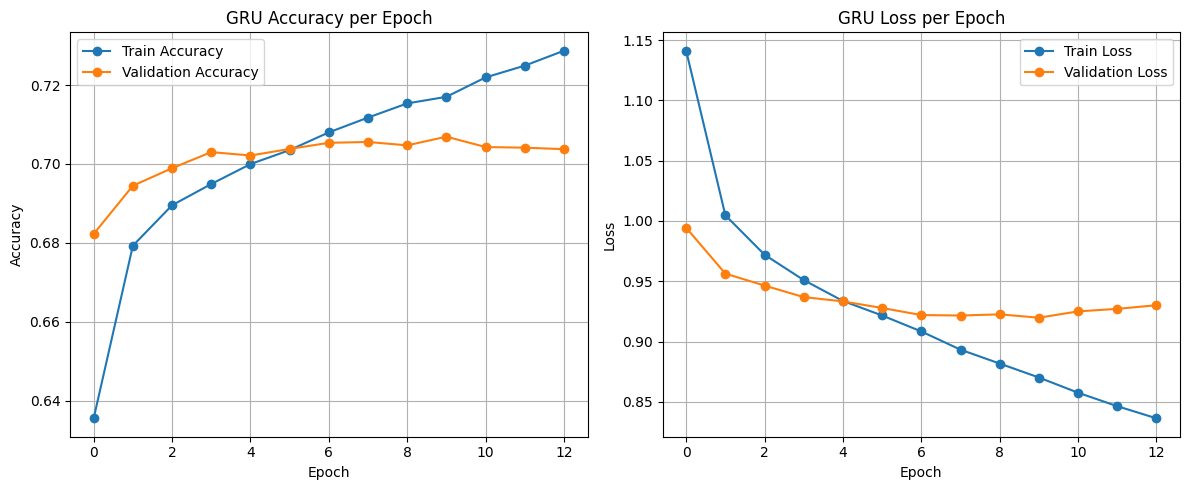

0

In [ ]:
# ============================================================================
# EXPERIMENT: GRU + WORD2VEC (OPTIMIZED SPEED & MULTI-GPU)
# ============================================================================

print("\n" + "="*60)
print("🧠 EXPERIMENT: GRU + WORD2VEC (GPU ACCELERATED)")
print("="*60)


# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (Fast Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<30} | {'Val Accuracy':<15}")
print("-" * 60)

configs = [
    {'id': 1, 'units': 64,  'desc': 'Light (64 units)'},
    {'id': 2, 'units': 128, 'desc': 'Heavy (128 units)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    with strategy.scope(): # <--- Open Multi-GPU Scope
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_size,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_seq_len, trainable=False),

            # OPTIMIZATION: recurrent_dropout=0 enables CuDNN (Fast GPU)
            # We use return_sequences=True + GlobalMaxPooling1D for better feature extraction
            GRU(conf['units'], return_sequences=True, recurrent_dropout=0),
            GlobalMaxPooling1D(),

            # We apply standard Dropout HERE instead of inside the GRU
            Dropout(0.3),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train briefly
    h = model.fit(X_train_nn, y_train_nn_split,
                  validation_data=(X_val_nn, y_val_nn_split),
                  epochs=3, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<30} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 60)
print(f"🏆 Best Architecture: {best_config['desc']}")

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING
# ------------------------------------------------------------------
print(f"🚀 Training Final GRU Model...")


with strategy.scope():
    gru_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_size,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=max_seq_len, trainable=False),

        GRU(best_config['units'], return_sequences=True, recurrent_dropout=0),
        GlobalMaxPooling1D(),

        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history_gru = gru_model.fit(
    X_train_nn, y_train_nn_split,
    validation_data=(X_val_nn, y_val_nn_split),
    epochs=15,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
training_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION
# ------------------------------------------------------------------
y_pred_probs = gru_model.predict(X_test_pad, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_nn, y_pred)
test_f1 = f1_score(y_test_nn, y_pred, average='macro')

results['GRU + Word2Vec'] = {'Accuracy': test_acc, 'F1-Macro': test_f1, 'Training Time': training_time}

print(f"\n✅ GRU Results: Acc={test_acc:.4f}, Time={training_time:.2f}s")

# Visuals
cm = confusion_matrix(y_test_nn, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - GRU ({best_config["desc"]})')
plt.show()

print(classification_report(y_test_nn, y_pred, target_names=label_encoder.classes_))
plot_training_history(history_gru, "GRU")

del gru_model
tf.keras.backend.clear_session()
gc.collect()

### LSTM


🧠 EXPERIMENT: LSTM + WORD2VEC (GPU ACCELERATED)

🧪 STARTING TUNING TRIALS...
Trial    | Config                         | Val Accuracy   
------------------------------------------------------------
1        | Light (64 units)               | 0.6874
2        | Heavy (128 units)              | 0.6926
------------------------------------------------------------
🏆 Best Architecture: Heavy (128 units)
🚀 Training Final LSTM Model...
Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5775 - loss: 1.3235 - val_accuracy: 0.6806 - val_loss: 1.0022
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6722 - loss: 1.0360 - val_accuracy: 0.6879 - val_loss: 0.9768
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6825 - loss: 0.9976 - val_accuracy: 0.6954 - val_loss: 0.9479
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6894 - loss: 0.9720 - val_accuracy: 0.6930 - val_loss: 0.9526
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━

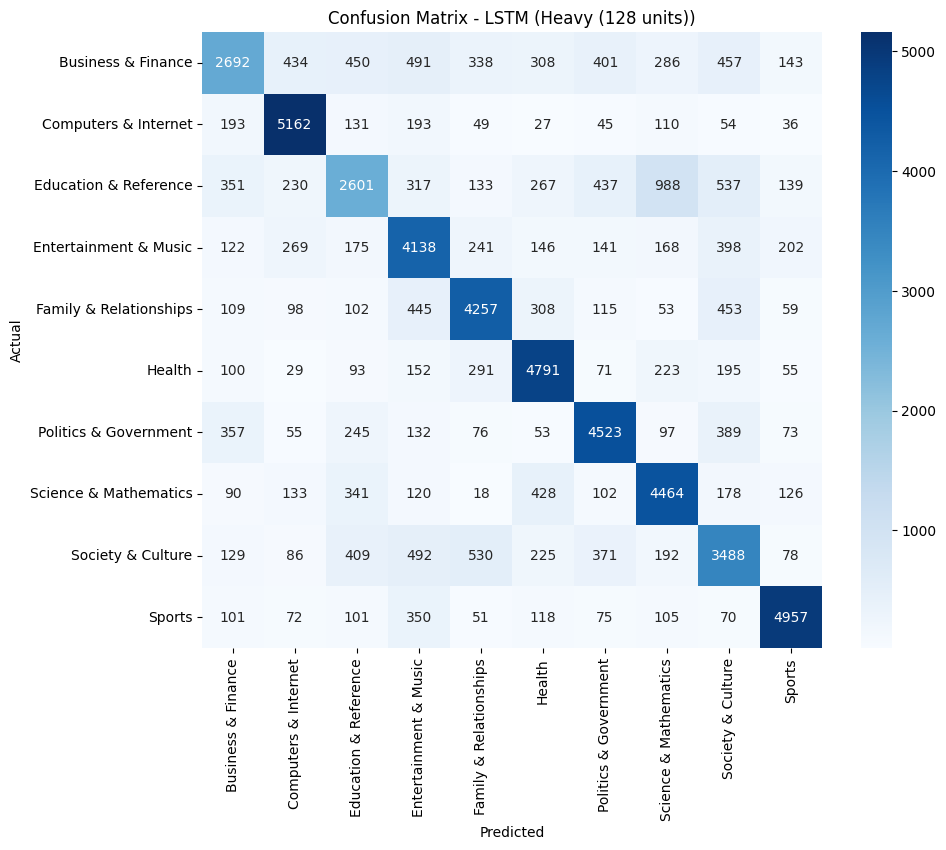

                        precision    recall  f1-score   support

    Business & Finance       0.63      0.45      0.53      6000
  Computers & Internet       0.79      0.86      0.82      6000
 Education & Reference       0.56      0.43      0.49      6000
 Entertainment & Music       0.61      0.69      0.65      6000
Family & Relationships       0.71      0.71      0.71      5999
                Health       0.72      0.80      0.76      6000
 Politics & Government       0.72      0.75      0.74      6000
 Science & Mathematics       0.67      0.74      0.70      6000
     Society & Culture       0.56      0.58      0.57      6000
                Sports       0.84      0.83      0.84      6000

              accuracy                           0.68     59999
             macro avg       0.68      0.68      0.68     59999
          weighted avg       0.68      0.68      0.68     59999



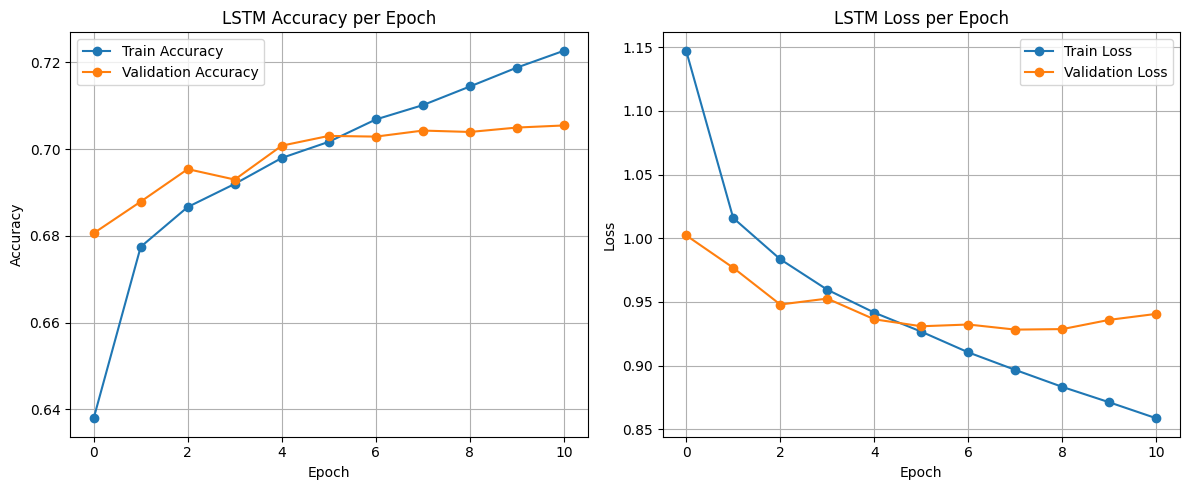

0

In [ ]:
# ============================================================================
# EXPERIMENT: LSTM + WORD2VEC (OPTIMIZED SPEED & MULTI-GPU)
# ============================================================================
print("\n" + "="*60)
print("🧠 EXPERIMENT: LSTM + WORD2VEC (GPU ACCELERATED)")
print("="*60)


# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (Fast Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<30} | {'Val Accuracy':<15}")
print("-" * 60)

configs = [
    {'id': 1, 'units': 64,  'desc': 'Light (64 units)'},
    {'id': 2, 'units': 128, 'desc': 'Heavy (128 units)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    with strategy.scope(): # <--- Multi-GPU Scope
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_size,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_seq_len, trainable=False),

            # OPTIMIZATION: recurrent_dropout=0 enables CuDNN (Fast GPU)
            # return_sequences=True allows GlobalMaxPooling to see the whole sentence context
            LSTM(conf['units'], return_sequences=True, recurrent_dropout=0),
            GlobalMaxPooling1D(),

            # We apply standard Dropout HERE instead
            Dropout(0.3),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train briefly
    h = model.fit(X_train_nn, y_train_nn_split,
                  validation_data=(X_val_nn, y_val_nn_split),
                  epochs=3, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<30} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 60)
print(f"🏆 Best Architecture: {best_config['desc']}")

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING
# ------------------------------------------------------------------
print(f"🚀 Training Final LSTM Model...")

with strategy.scope():
    lstm_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_size,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=max_seq_len, trainable=False),

        LSTM(best_config['units'], return_sequences=True, recurrent_dropout=0),
        GlobalMaxPooling1D(),

        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history_lstm = lstm_model.fit(
    X_train_nn, y_train_nn_split,
    validation_data=(X_val_nn, y_val_nn_split),
    epochs=15,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
training_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION
# ------------------------------------------------------------------
y_pred_probs = lstm_model.predict(X_test_pad, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_nn, y_pred)
test_f1 = f1_score(y_test_nn, y_pred, average='macro')

results['LSTM + Word2Vec'] = {'Accuracy': test_acc, 'F1-Macro': test_f1, 'Training Time': training_time}

print(f"\n✅ LSTM Results: Acc={test_acc:.4f}, Time={training_time:.2f}s")

# Visuals
cm = confusion_matrix(y_test_nn, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - LSTM ({best_config["desc"]})')
plt.show()

print(classification_report(y_test_nn, y_pred, target_names=label_encoder.classes_))
plot_training_history(history_lstm, "LSTM")

del lstm_model
tf.keras.backend.clear_session()
gc.collect()

### Bidirectional SimpleRNN


🧠 EXPERIMENT: BIDIRECTIONAL SIMPLERNN + WORD2VEC (DUAL GPU)

🧪 STARTING TUNING TRIALS...
Trial    | Config                              | Val Accuracy   
-----------------------------------------------------------------
1        | Light (Bi-64 units, 0.2 drop)       | 0.6835
2        | Heavy (Bi-128 units, 0.3 drop)      | 0.6837
-----------------------------------------------------------------
🏆 Best Architecture: Heavy (Bi-128 units, 0.3 drop)
🚀 Training Final Bi-SimpleRNN Model (Heavy (Bi-128 units, 0.3 drop))...
Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 201s 170ms/step - accuracy: 0.4946 - loss: 1.5098 - val_accuracy: 0.6568 - val_loss: 1.0630
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 198s 169ms/step - accuracy: 0.6520 - loss: 1.0848 - val_accuracy: 0.6748 - val_loss: 1.0168
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 198s 170ms/step - accuracy: 0.6690 - loss: 1.0390 - val_accuracy: 0.6764 - val_loss: 1.0079
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 198s 169ms/step - accuracy: 0.676

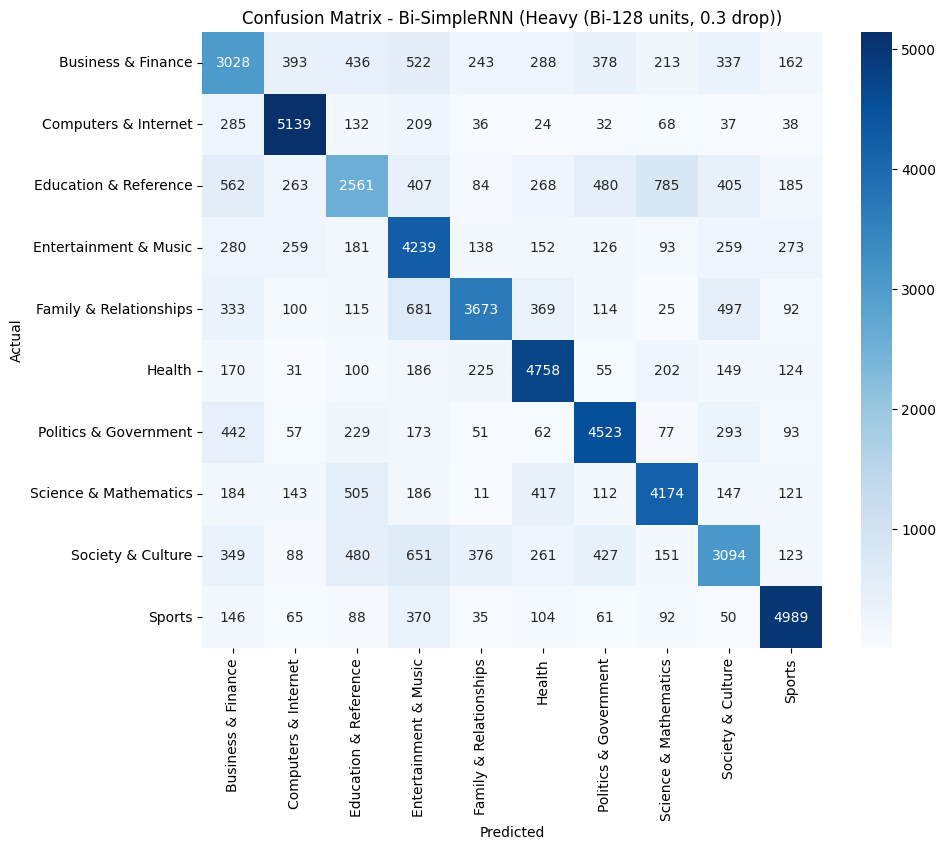


Classification Report:

                        precision    recall  f1-score   support

    Business & Finance       0.52      0.50      0.51      6000
  Computers & Internet       0.79      0.86      0.82      6000
 Education & Reference       0.53      0.43      0.47      6000
 Entertainment & Music       0.56      0.71      0.62      6000
Family & Relationships       0.75      0.61      0.68      5999
                Health       0.71      0.79      0.75      6000
 Politics & Government       0.72      0.75      0.73      6000
 Science & Mathematics       0.71      0.70      0.70      6000
     Society & Culture       0.59      0.52      0.55      6000
                Sports       0.80      0.83      0.82      6000

              accuracy                           0.67     59999
             macro avg       0.67      0.67      0.67     59999
          weighted avg       0.67      0.67      0.67     59999



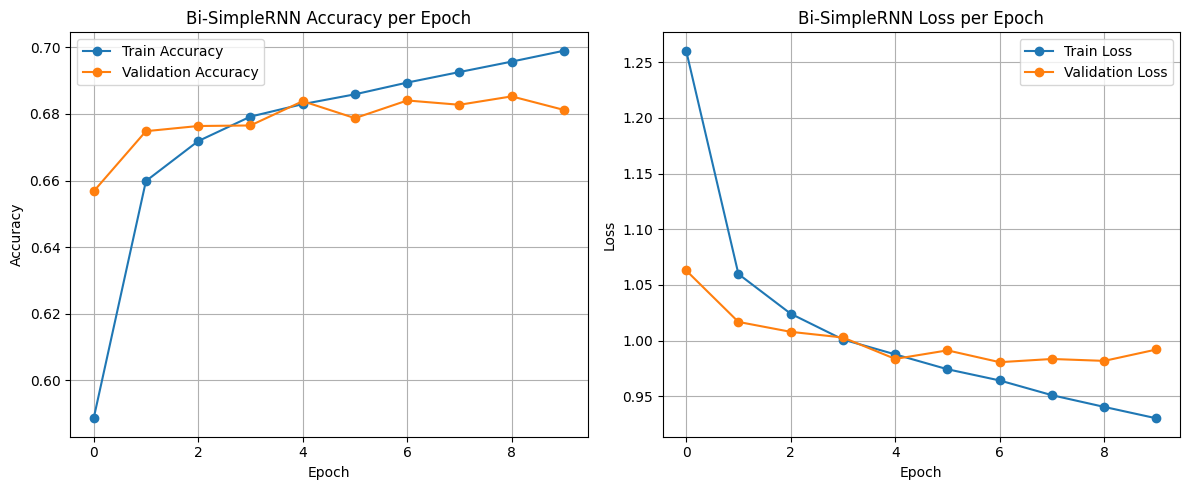

0

In [ ]:
# ============================================================================
# EXPERIMENT: BIDIRECTIONAL SIMPLERNN + WORD2VEC (DUAL GPU ENABLED)
# ============================================================================
print("\n" + "="*60)
print("🧠 EXPERIMENT: BIDIRECTIONAL SIMPLERNN + WORD2VEC (DUAL GPU)")
print("="*60)

# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (The Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<35} | {'Val Accuracy':<15}")
print("-" * 65)

configs = [
    {'id': 1, 'units': 64,  'drop': 0.2, 'desc': 'Light (Bi-64 units, 0.2 drop)'},
    {'id': 2, 'units': 128, 'drop': 0.3, 'desc': 'Heavy (Bi-128 units, 0.3 drop)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    # WRAPPER FOR DUAL GPU
    with strategy.scope():
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_size,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_seq_len, trainable=False),

            # Architecture remains EXACTLY as you requested
            Bidirectional(SimpleRNN(conf['units'], return_sequences=True, recurrent_dropout=0)),
            GlobalMaxPooling1D(),
            # External Dropout
            Dropout(0.3),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Batch size scaled for Dual GPU
    h = model.fit(X_train_nn, y_train_nn_split,
                  validation_data=(X_val_nn, y_val_nn_split),
                  epochs=5, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<35} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 65)
print(f"🏆 Best Architecture: {best_config['desc']}")
print("="*60)

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING (With Best Config)
# ------------------------------------------------------------------
print(f"🚀 Training Final Bi-SimpleRNN Model ({best_config['desc']})...")

with strategy.scope():
    birnn_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_size,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=max_seq_len, trainable=False),

        Bidirectional(SimpleRNN(best_config['units'], return_sequences=True, recurrent_dropout=0)),
            GlobalMaxPooling1D(),

            # External Dropout
            Dropout(0.3),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    birnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train (Using Global Batch Size)
start_time = time.time()
history_birnn = birnn_model.fit(
    X_train_nn, y_train_nn_split,
    validation_data=(X_val_nn, y_val_nn_split),
    epochs=15,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
training_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION & STORAGE
# ------------------------------------------------------------------
print("\n🔍 Evaluating Bidirectional SimpleRNN...")
y_pred_probs = birnn_model.predict(X_test_pad, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_nn, y_pred)
test_f1 = f1_score(y_test_nn, y_pred, average='macro')

print(f"\n✅ Bi-SimpleRNN + Word2Vec Results:")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test F1-Macro: {test_f1:.4f}")

# Store results
results['Bi-SimpleRNN + Word2Vec'] = {
    'Accuracy': test_acc,
    'F1-Macro': test_f1,
    'Training Time': training_time
}

# Visuals
cm = confusion_matrix(y_test_nn, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Bi-SimpleRNN ({best_config["desc"]})')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test_nn, y_pred, target_names=label_encoder.classes_))
plot_training_history(history_birnn, model_name="Bi-SimpleRNN")

# Cleanup
del birnn_model
tf.keras.backend.clear_session()
gc.collect()

### Bidirectional GRU


🧠 EXPERIMENT: Bi-GRU + WORD2VEC (GPU ACCELERATED)

🧪 STARTING TUNING TRIALS...
Trial    | Config                         | Val Accuracy   
------------------------------------------------------------
1        | Light (Bi-64)                  | 0.6964
2        | Heavy (Bi-128)                 | 0.6992
------------------------------------------------------------
🏆 Best Architecture: Heavy (Bi-128)
🚀 Training Final Bi-GRU Model...
Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5878 - loss: 1.2891 - val_accuracy: 0.6859 - val_loss: 0.9817
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6793 - loss: 1.0043 - val_accuracy: 0.6904 - val_loss: 0.9557
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6876 - loss: 0.9704 - val_accuracy: 0.6973 - val_loss: 0.9413
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6957 - loss: 0.9448 - val_accuracy: 0.6998 - val_loss: 0.9360
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━

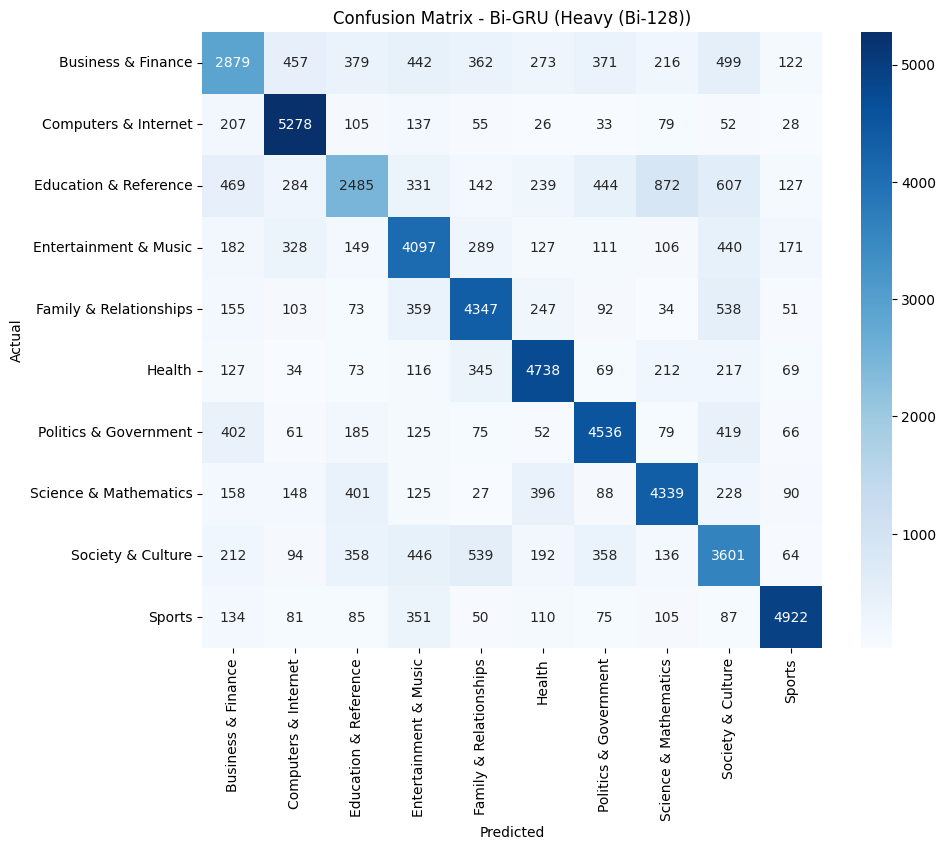

                        precision    recall  f1-score   support

    Business & Finance       0.58      0.48      0.53      6000
  Computers & Internet       0.77      0.88      0.82      6000
 Education & Reference       0.58      0.41      0.48      6000
 Entertainment & Music       0.63      0.68      0.65      6000
Family & Relationships       0.70      0.72      0.71      5999
                Health       0.74      0.79      0.76      6000
 Politics & Government       0.73      0.76      0.75      6000
 Science & Mathematics       0.70      0.72      0.71      6000
     Society & Culture       0.54      0.60      0.57      6000
                Sports       0.86      0.82      0.84      6000

              accuracy                           0.69     59999
             macro avg       0.68      0.69      0.68     59999
          weighted avg       0.68      0.69      0.68     59999



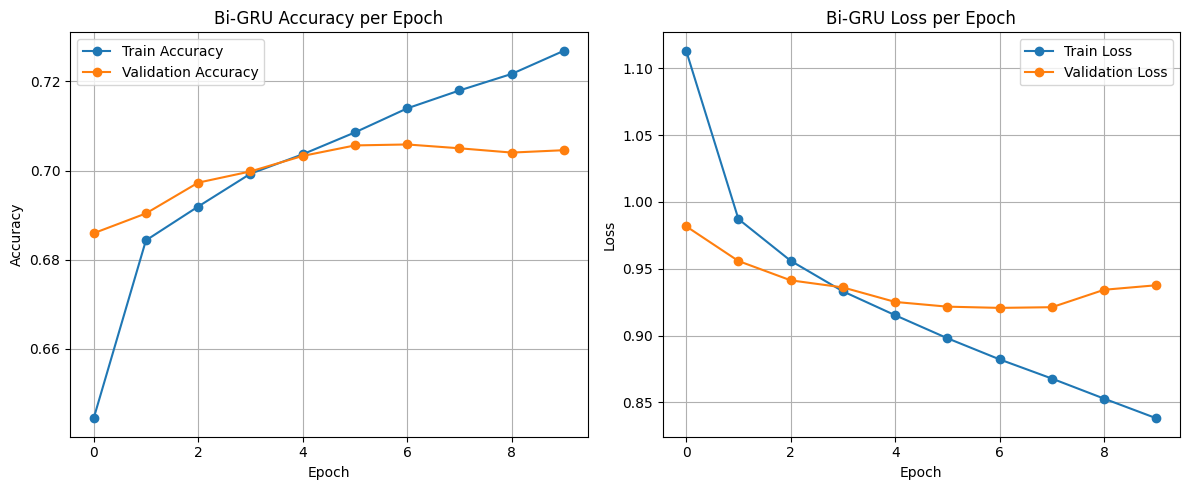

0

In [ ]:
# ============================================================================
# EXPERIMENT: BIDIRECTIONAL GRU (OPTIMIZED SPEED & MULTI-GPU)
# ============================================================================
print("\n" + "="*60)
print("🧠 EXPERIMENT: Bi-GRU + WORD2VEC (GPU ACCELERATED)")
print("="*60)

# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (Fast Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<30} | {'Val Accuracy':<15}")
print("-" * 60)

configs = [
    {'id': 1, 'units': 64,  'desc': 'Light (Bi-64)'},
    {'id': 2, 'units': 128, 'desc': 'Heavy (Bi-128)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    with strategy.scope():
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_size,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_seq_len, trainable=False),

            # OPTIMIZATION: recurrent_dropout=0 enables CuDNN
            Bidirectional(GRU(conf['units'], return_sequences=True, recurrent_dropout=0)),
            GlobalMaxPooling1D(),

            # External Dropout
            Dropout(0.3),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    h = model.fit(X_train_nn, y_train_nn_split,
                  validation_data=(X_val_nn, y_val_nn_split),
                  epochs=3, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<30} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 60)
print(f"🏆 Best Architecture: {best_config['desc']}")

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING
# ------------------------------------------------------------------
print(f"🚀 Training Final Bi-GRU Model...")

with strategy.scope():
    bigru_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_size,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=max_seq_len, trainable=False),

        Bidirectional(GRU(best_config['units'], return_sequences=True, recurrent_dropout=0)),
        GlobalMaxPooling1D(),

        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    bigru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history_bigru = bigru_model.fit(
    X_train_nn, y_train_nn_split,
    validation_data=(X_val_nn, y_val_nn_split),
    epochs=15,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
training_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION
# ------------------------------------------------------------------
y_pred_probs = bigru_model.predict(X_test_pad, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_nn, y_pred)
test_f1 = f1_score(y_test_nn, y_pred, average='macro')

results['Bi-GRU + Word2Vec'] = {'Accuracy': test_acc, 'F1-Macro': test_f1, 'Training Time': training_time}

print(f"\n✅ Bi-GRU Results: Acc={test_acc:.4f}, Time={training_time:.2f}s")

# Visuals
cm = confusion_matrix(y_test_nn, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Bi-GRU ({best_config["desc"]})')
plt.show()

print(classification_report(y_test_nn, y_pred, target_names=label_encoder.classes_))
plot_training_history(history_bigru, "Bi-GRU")

del bigru_model
tf.keras.backend.clear_session()
gc.collect()

### Bidirectional LSTM


🧠 EXPERIMENT: Bi-LSTM + WORD2VEC (GPU ACCELERATED)

🧪 STARTING TUNING TRIALS...
Trial    | Config                         | Val Accuracy   
------------------------------------------------------------
1        | Light (Bi-64)                  | 0.6911
2        | Heavy (Bi-128)                 | 0.6957
------------------------------------------------------------
🏆 Best Architecture: Heavy (Bi-128)
🚀 Training Final Bi-LSTM Model...
Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5877 - loss: 1.2804 - val_accuracy: 0.6820 - val_loss: 0.9928
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6734 - loss: 1.0161 - val_accuracy: 0.6919 - val_loss: 0.9609
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6850 - loss: 0.9785 - val_accuracy: 0.6926 - val_loss: 0.9451
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6921 - loss: 0.9544 - val_accuracy: 0.7011 - val_loss: 0.9354
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━

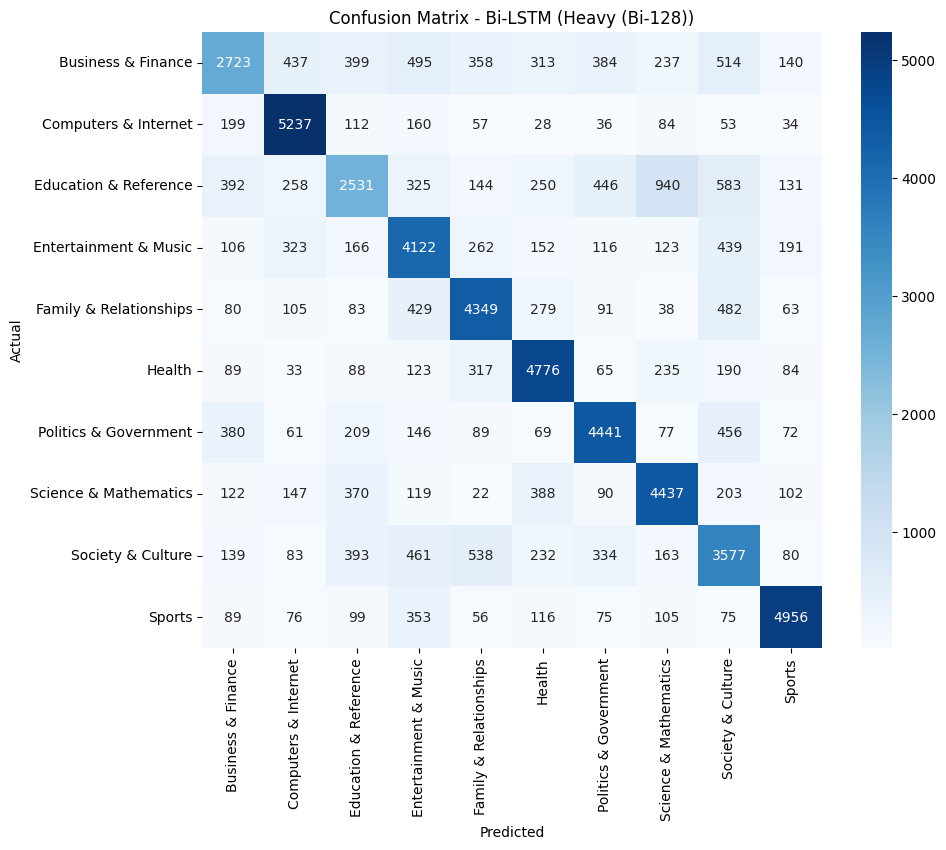

                        precision    recall  f1-score   support

    Business & Finance       0.63      0.45      0.53      6000
  Computers & Internet       0.77      0.87      0.82      6000
 Education & Reference       0.57      0.42      0.48      6000
 Entertainment & Music       0.61      0.69      0.65      6000
Family & Relationships       0.70      0.72      0.71      5999
                Health       0.72      0.80      0.76      6000
 Politics & Government       0.73      0.74      0.74      6000
 Science & Mathematics       0.69      0.74      0.71      6000
     Society & Culture       0.54      0.60      0.57      6000
                Sports       0.85      0.83      0.84      6000

              accuracy                           0.69     59999
             macro avg       0.68      0.69      0.68     59999
          weighted avg       0.68      0.69      0.68     59999



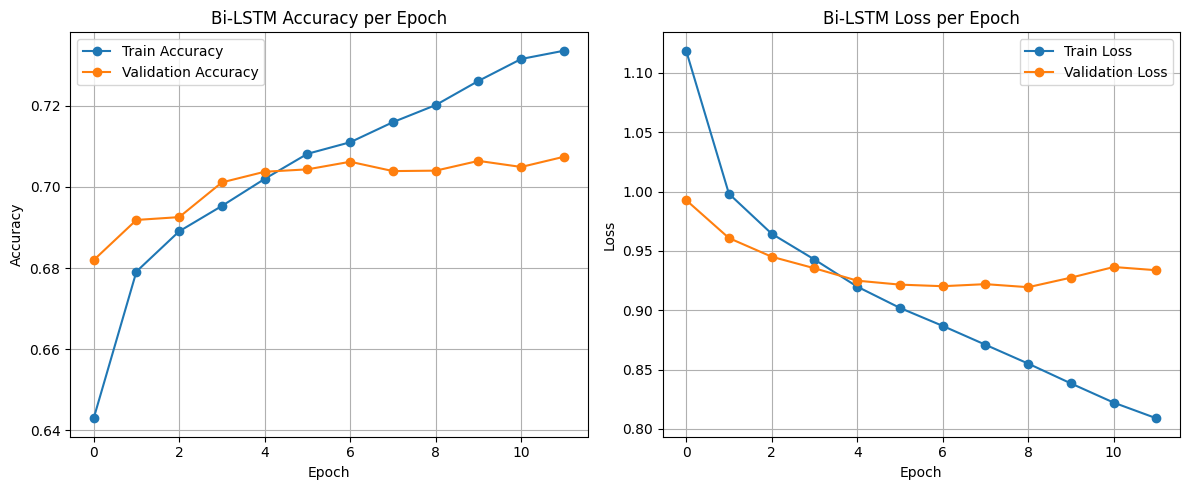

0

In [ ]:
# ============================================================================
# EXPERIMENT: BIDIRECTIONAL LSTM (OPTIMIZED SPEED & MULTI-GPU)
# ============================================================================
print("\n" + "="*60)
print("🧠 EXPERIMENT: Bi-LSTM + WORD2VEC (GPU ACCELERATED)")
print("="*60)

# ------------------------------------------------------------------
# STEP 1: HYPERPARAMETER TUNING (Fast Trials)
# ------------------------------------------------------------------
print("\n🧪 STARTING TUNING TRIALS...")
print(f"{'Trial':<8} | {'Config':<30} | {'Val Accuracy':<15}")
print("-" * 60)

configs = [
    {'id': 1, 'units': 64,  'desc': 'Light (Bi-64)'},
    {'id': 2, 'units': 128, 'desc': 'Heavy (Bi-128)'}
]

best_config = configs[0]
best_val_acc = 0.0

for conf in configs:
    tf.keras.backend.clear_session()

    with strategy.scope():
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_size,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_seq_len, trainable=False),

            # OPTIMIZATION: recurrent_dropout=0 enables CuDNN
            # return_sequences=True allows GlobalMaxPooling to capture features from the whole sequence
            Bidirectional(LSTM(conf['units'], return_sequences=True, recurrent_dropout=0)),
            GlobalMaxPooling1D(),

            # External Dropout
            Dropout(0.3),
            Dense(len(label_encoder.classes_), activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    h = model.fit(X_train_nn, y_train_nn_split,
                  validation_data=(X_val_nn, y_val_nn_split),
                  epochs=3, batch_size=GLOBAL_BATCH_SIZE, verbose=0)

    val_acc = max(h.history['val_accuracy'])
    print(f"{conf['id']:<8} | {conf['desc']:<30} | {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = conf

print("-" * 60)
print(f"🏆 Best Architecture: {best_config['desc']}")

# ------------------------------------------------------------------
# STEP 2: FINAL TRAINING
# ------------------------------------------------------------------
print(f"🚀 Training Final Bi-LSTM Model...")

with strategy.scope():
    bilstm_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_size,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=max_seq_len, trainable=False),

        Bidirectional(LSTM(best_config['units'], return_sequences=True, recurrent_dropout=0)),
        GlobalMaxPooling1D(),

        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history_bilstm = bilstm_model.fit(
    X_train_nn, y_train_nn_split,
    validation_data=(X_val_nn, y_val_nn_split),
    epochs=15,
    batch_size=GLOBAL_BATCH_SIZE,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
training_time = time.time() - start_time

# ------------------------------------------------------------------
# STEP 3: EVALUATION
# ------------------------------------------------------------------
y_pred_probs = bilstm_model.predict(X_test_pad, batch_size=GLOBAL_BATCH_SIZE)
y_pred = y_pred_probs.argmax(axis=1)

test_acc = accuracy_score(y_test_nn, y_pred)
test_f1 = f1_score(y_test_nn, y_pred, average='macro')

results['Bi-LSTM + Word2Vec'] = {'Accuracy': test_acc, 'F1-Macro': test_f1, 'Training Time': training_time}

print(f"\n✅ Bi-LSTM Results: Acc={test_acc:.4f}, Time={training_time:.2f}s")

# Visuals
cm = confusion_matrix(y_test_nn, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Bi-LSTM ({best_config["desc"]})')
plt.show()

print(classification_report(y_test_nn, y_pred, target_names=label_encoder.classes_))
plot_training_history(history_bilstm, "Bi-LSTM")

del bilstm_model
tf.keras.backend.clear_session()
gc.collect()

### Final Comparison and Conclusion


📊 FINAL PROJECT ANALYSIS

🏆 LEADERBOARD (Ranked by Accuracy):
                         Accuracy  F1-Macro  Training Time
Bi-GRU + Word2Vec        0.687045  0.682518     199.028726
GRU + Word2Vec           0.686928  0.682360     187.750365
Bi-LSTM + Word2Vec       0.685828  0.680593     238.873254
LSTM + Word2Vec          0.684561  0.679396     160.879110
SimpleRNN + Word2Vec     0.670028  0.666415    1803.316792
Bi-SimpleRNN + Word2Vec  0.669644  0.665880    1982.817830
DNN + TF-IDF             0.666861  0.661843      88.975850
Naive Bayes + TF-IDF     0.662878  0.658473       0.021648
DNN + Word2Vec           0.596277  0.587758     114.979507

🥇 BEST PERFORMING MODEL: Bi-GRU + Word2Vec (Accuracy: 0.6870)
📉 WORST PERFORMING MODEL: DNN + Word2Vec (Accuracy: 0.5963)

⚔️ HEAD-TO-HEAD COMPARISON
   Traditional ML (Naive Bayes + TF-IDF): 0.6629
   Best Deep Learning (Bi-GRU + Word2Vec): 0.6870
   >> Deep Learning outperformed ML by 2.42%


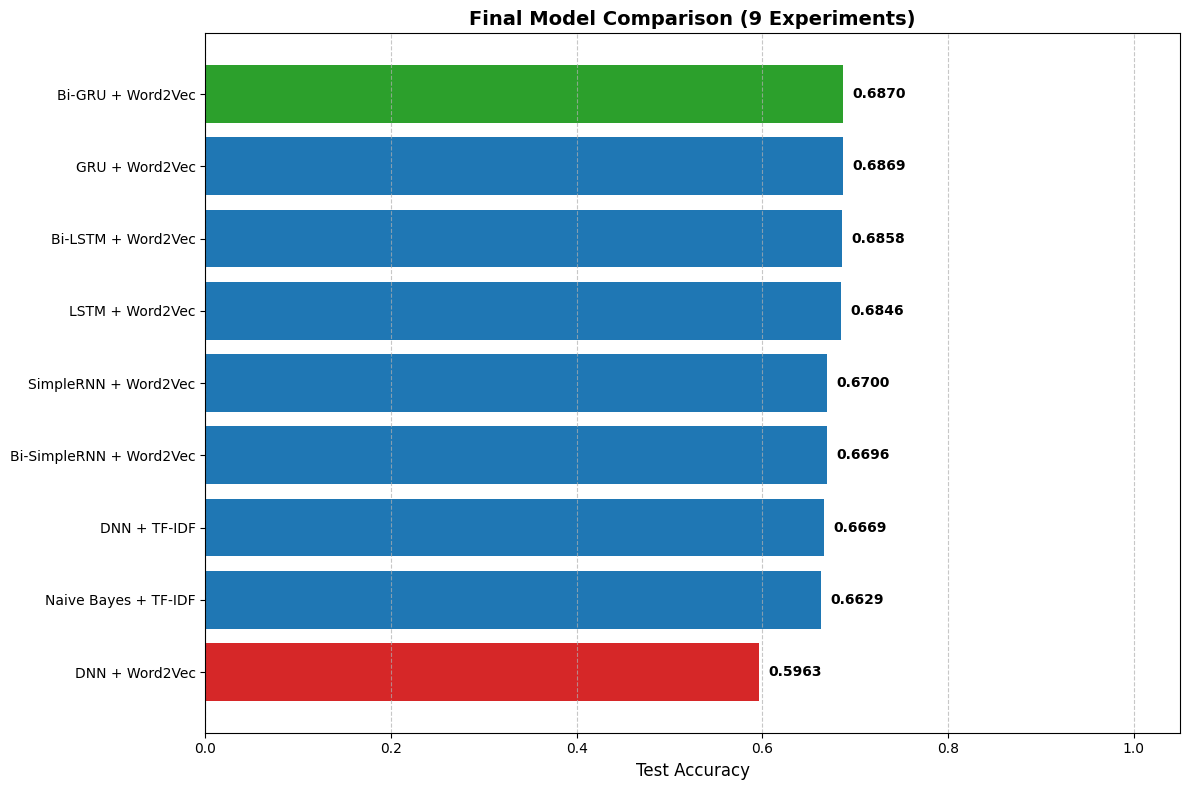

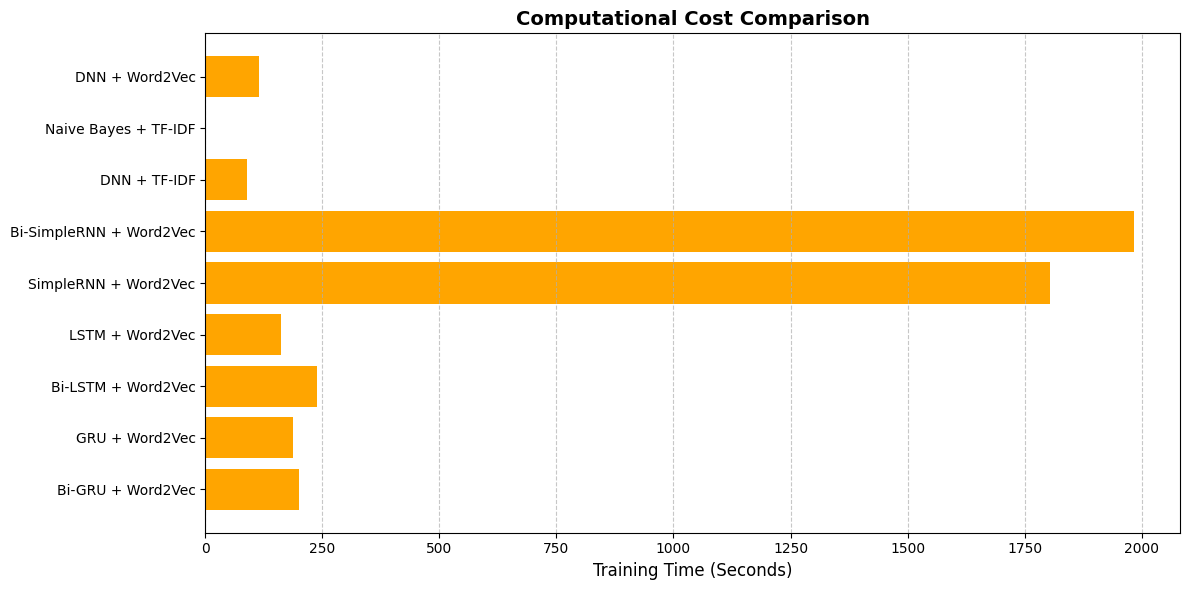


✅ Project Experiments Completed successfully!


In [ ]:
# ============================================================================
# FINAL DELIVERABLE: COMPARATIVE ANALYSIS & CONCLUSION
# ============================================================================

print("\n📊 FINAL PROJECT ANALYSIS")
print("="*80)

# 1. Convert the 'results' dictionary to a DataFrame for easy analysis
# We expect 'results' to contain keys like 'Naive Bayes + TF-IDF', 'LSTM + Word2Vec', etc.
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values(by='Accuracy', ascending=False)

print("\n🏆 LEADERBOARD (Ranked by Accuracy):")
print(df_results[['Accuracy', 'F1-Macro', 'Training Time']])

# 2. Identify Best and Worst Models
best_model_name = df_results['Accuracy'].idxmax()
best_acc = df_results.loc[best_model_name, 'Accuracy']

worst_model_name = df_results['Accuracy'].idxmin()
worst_acc = df_results.loc[worst_model_name, 'Accuracy']

print(f"\n🥇 BEST PERFORMING MODEL: {best_model_name} (Accuracy: {best_acc:.4f})")
print(f"📉 WORST PERFORMING MODEL: {worst_model_name} (Accuracy: {worst_acc:.4f})")

# 3. Comparison: ML vs. Best Deep Learning
# Identifying the ML model (assuming it contains 'Naive Bayes', 'Logistic', or 'Random Forest')
ml_row = df_results[df_results.index.str.contains('Naive Bayes|Logistic|Random Forest')]
if not ml_row.empty:
    ml_acc = ml_row.iloc[0]['Accuracy']
    ml_name = ml_row.index[0]

    print(f"\n⚔️ HEAD-TO-HEAD COMPARISON")
    print(f"   Traditional ML ({ml_name}): {ml_acc:.4f}")
    print(f"   Best Deep Learning ({best_model_name}): {best_acc:.4f}")

    diff = best_acc - ml_acc
    if diff > 0:
        print(f"   >> Deep Learning outperformed ML by {diff*100:.2f}%")
    else:
        print(f"   >> ML outperformed Deep Learning by {abs(diff)*100:.2f}%")

# 4. Final Visualization
plt.figure(figsize=(12, 8))
# Color the best model green, worst red, others blue
colors = ['#2ca02c' if x == best_model_name else '#d62728' if x == worst_model_name else '#1f77b4' for x in df_results.index]

bars = plt.barh(df_results.index, df_results['Accuracy'], color=colors)
plt.xlabel('Test Accuracy', fontsize=12)
plt.title('Final Model Comparison (9 Experiments)', fontsize=14, fontweight='bold')
plt.xlim(0, 1.05) # Space for text
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', ha='left', va='center', fontweight='bold', color='black')

plt.gca().invert_yaxis() # Best model on top
plt.tight_layout()
plt.show()

# 5. Training Time Comparison
plt.figure(figsize=(12, 6))
plt.barh(df_results.index, df_results['Training Time'], color='orange')
plt.xlabel('Training Time (Seconds)', fontsize=12)
plt.title('Computational Cost Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n✅ Project Experiments Completed successfully!")

# ML MODEL(NAIVE BAYES) VS BEST & WORST NN MODEL

✅ Dynamic Identification Complete:
   • ML Baseline: Naive Bayes + TF-IDF (0.6629)
   • Best NN:     Bi-GRU + Word2Vec (0.6870)
   • Worst NN:    DNN + Word2Vec (0.5963)
📊 Saved Plot: ML_vs_Best_Comparison.png


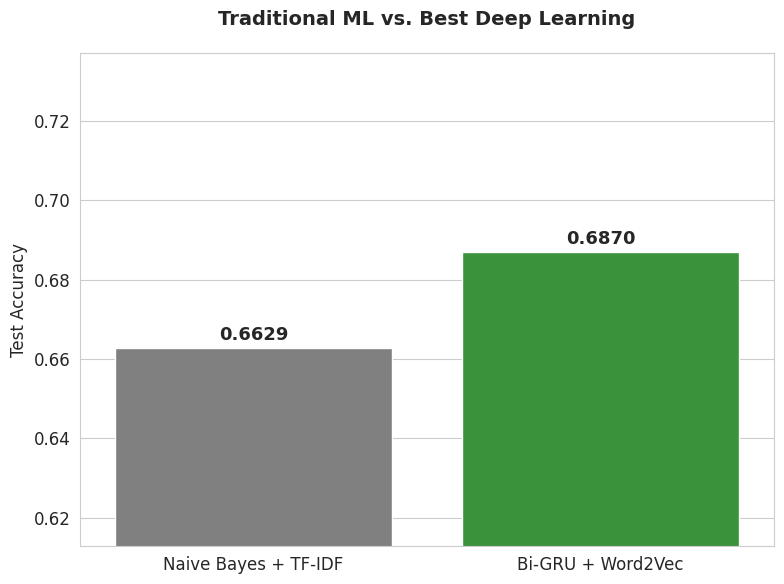

📊 Saved Plot: ML_vs_Worst_Comparison.png


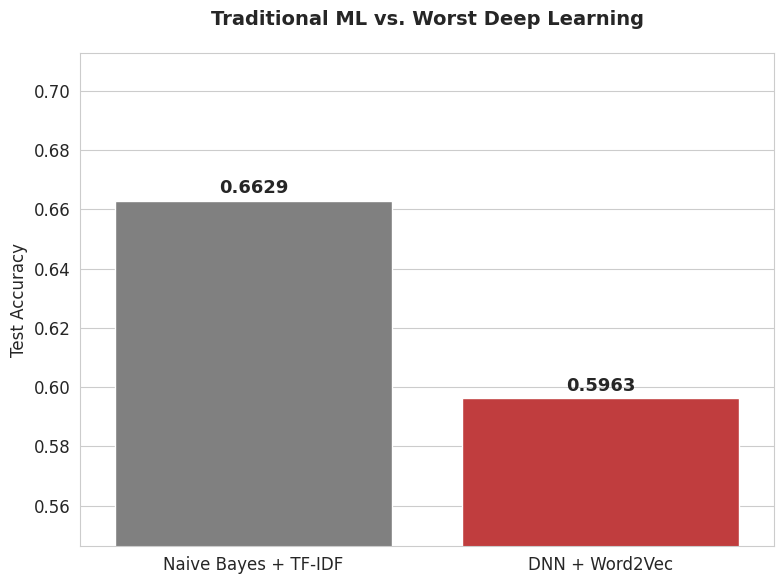

In [ ]:
# ==========================================
# 1. FETCH DATA (Dynamic)
# ==========================================
# We assume 'results' variable exists from your previous training cells
if 'results' not in locals():
    raise ValueError("⚠️ The 'results' dictionary is missing! Make sure you ran the training cells first.")

# Convert to DataFrame for easy handling
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values(by='Accuracy', ascending=False)

# ==========================================
# 2. IDENTIFY MODELS DYNAMICALLY
# ==========================================
# A. Find ML Baseline (Look for "Naive Bayes")
ml_row = df_results[df_results.index.str.contains('Naive Bayes')]
if ml_row.empty:
    raise ValueError("⚠️ Could not find 'Naive Bayes' in results.")
ml_name = ml_row.index[0]
ml_acc = ml_row.iloc[0]['Accuracy']

# B. Find Best Model (Overall Max Accuracy)
best_model_name = df_results['Accuracy'].idxmax()
best_acc = df_results.loc[best_model_name, 'Accuracy']

# C. Find Worst Neural Network (Min Accuracy)
# We exclude the ML baseline from this search to ensure we find the worst NN
nn_only_df = df_results.drop(index=ml_name)
worst_nn_name = nn_only_df['Accuracy'].idxmin()
worst_nn_acc = nn_only_df.loc[worst_nn_name, 'Accuracy']

print(f"✅ Dynamic Identification Complete:")
print(f"   • ML Baseline: {ml_name} ({ml_acc:.4f})")
print(f"   • Best NN:     {best_model_name} ({best_acc:.4f})")
print(f"   • Worst NN:    {worst_nn_name} ({worst_nn_acc:.4f})")

# ==========================================
# 3. PLOTTING FUNCTION
# ==========================================
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_dynamic_comparison(name_a, acc_a, name_b, acc_b, title, filename, color_b):
    plt.figure(figsize=(8, 6))

    # Create temporary dataframe for plotting
    plot_data = pd.DataFrame({
        'Model': [name_a, name_b],
        'Accuracy': [acc_a, acc_b]
    })

    colors = ['grey', color_b]
    ax = sns.barplot(x='Model', y='Accuracy', data=plot_data, palette=colors)

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.xlabel('')

    # Zoom Y-axis to show differences
    min_val = min(acc_a, acc_b)
    max_val = max(acc_a, acc_b)
    plt.ylim(min_val - 0.05, max_val + 0.05)

    # Add labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points',
                   fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"📊 Saved Plot: {filename}")
    plt.show()

# ==========================================
# 4. GENERATE PLOTS
# ==========================================

# Plot 1: ML vs Best NN
plot_dynamic_comparison(
    ml_name, ml_acc,
    best_model_name, best_acc,
    'Traditional ML vs. Best Deep Learning',
    'ML_vs_Best_Comparison.png',
    '#2ca02c' # Green
)

# Plot 2: ML vs Worst NN
plot_dynamic_comparison(
    ml_name, ml_acc,
    worst_nn_name, worst_nn_acc,
    'Traditional ML vs. Worst Deep Learning',
    'ML_vs_Worst_Comparison.png',
    '#d62728' # Red
)